In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt
from nltk.stem import WordNetLemmatizer as wl, PorterStemmer as porter
from gensim import corpora

from sklearn.feature_extraction.text import TfidfVectorizer as tf
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV as rsv, cross_val_score as cvs
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,roc_auc_score,confusion_matrix,log_loss,\
precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

from PIL import Image
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore',message="numpy.dtype size changed")
warnings.filterwarnings('ignore',message="numpy.ufunc size changed")
import joblib

In [2]:
df=pd.read_csv(r"E:\FlipRobo\NLP Projects to do\Malignant Comments Classifier Project\train.csv")

test=pd.read_csv(r"E:\FlipRobo\NLP Projects to do\Malignant Comments Classifier Project\test.csv")

In [3]:
df.head(7)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [4]:
test.head(7)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...


In [5]:
print("In the training dataset\nNumber of columns=",df.shape[1],'\nNumber of Rows=',df.shape[0],'\nName of columns=\n',df.columns.values)

In the training dataset
Number of columns= 8 
Number of Rows= 159571 
Name of columns=
 ['id' 'comment_text' 'malignant' 'highly_malignant' 'rude' 'threat'
 'abuse' 'loathe']


In [6]:
print("In the test dataset\nNumber of columns=",test.shape[1],'\nNumber of Rows=',test.shape[0],'\nName of columns=\n',test.columns.values)

In the test dataset
Number of columns= 2 
Number of Rows= 153164 
Name of columns=
 ['id' 'comment_text']


In [7]:
#checking if there is any duplicated values in training dataset
print('Number of duplicated values:-',df.duplicated().sum())

Number of duplicated values:- 0


In [8]:
#checking if there is any duplicated values in test dataset
print('Number of duplicated values:-',test.duplicated().sum())

Number of duplicated values:- 0


In [9]:
#checking for null values in training dataset
for i in df.columns:
    null=df[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'
There are no null values in  'malignant'
There are no null values in  'highly_malignant'
There are no null values in  'rude'
There are no null values in  'threat'
There are no null values in  'abuse'
There are no null values in  'loathe'


In [10]:
#checking for null values in test dataset
for i in test.columns:
    null=test[i].isnull().sum()
    if null>0:
        print('Number of Null Values At  '+"'"+ i+"'" ,'==  ',null )
    else:
        print('There are no null values in  '+"'"+ i+"'")

There are no null values in  'id'
There are no null values in  'comment_text'


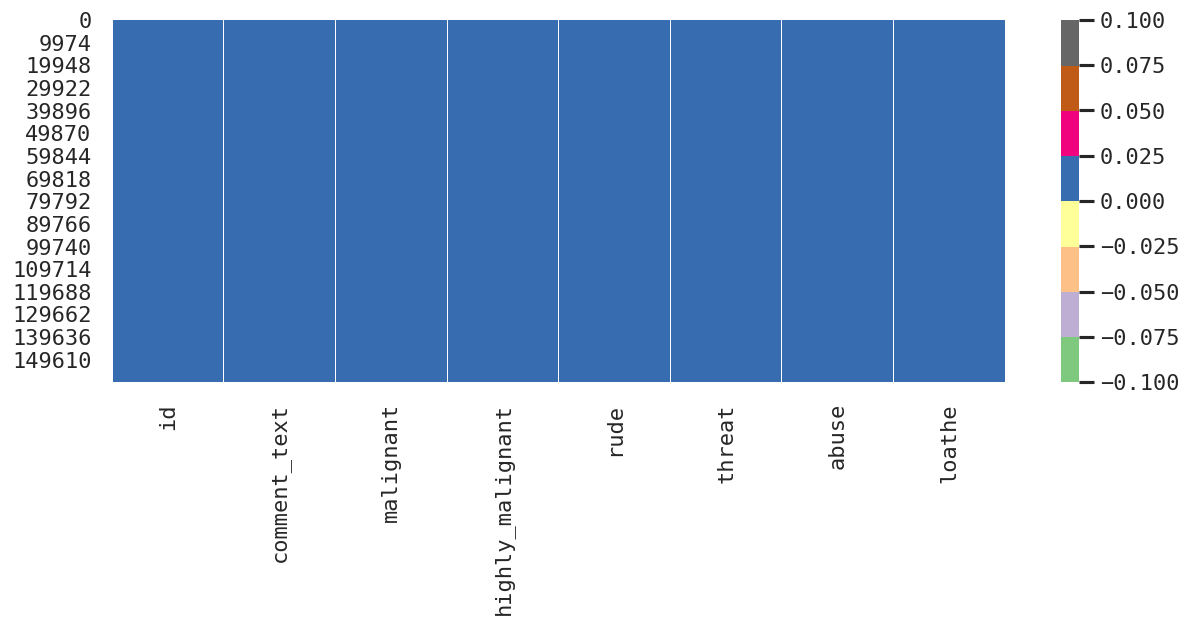

In [11]:
#heatmap of null values
sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=0.8)
plt.figure(figsize=(12,4),dpi=120)
sns.heatmap(df.isnull(),cmap='Accent')
plt.show()

In [12]:
#dropping unwanted columns as we'll be working on the comment_text and their categories_
cmt=df.copy()
cmt.drop(['id'],axis=1,inplace=True)

In [13]:
test.drop(['id'],axis=1,inplace=True)

In [14]:
#adding a new column which represent a normal statement

labels= ['malignant','highly_malignant','rude','threat','abuse','loathe']
cmt['normal']=1-cmt[labels].max(axis=1)

In [15]:
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0


```The column named 'normal' represents the columns which are not falling under 'malignant','highly_malignant','rude','threat','abuse','loathe' categories```

In [16]:
#adding a column 'raw length' to the dataset which will show the length of characters in column 'comment_text'
cmt['raw length']= cmt.comment_text.str.len().astype('int64')
cmt.head(7)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44


In [17]:
#value counts of  label columns
values=['malignant','highly_malignant','rude','threat','abuse','loathe']
for i in values:
    vc=cmt[i].value_counts()
    print('VALUE COUNT OF UNIQUE VALUES IN ' +"'"+ i+"' :\n ",vc,'\n')

VALUE COUNT OF UNIQUE VALUES IN 'malignant' :
  0    144277
1     15294
Name: malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'highly_malignant' :
  0    157976
1      1595
Name: highly_malignant, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'rude' :
  0    151122
1      8449
Name: rude, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'threat' :
  0    159093
1       478
Name: threat, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'abuse' :
  0    151694
1      7877
Name: abuse, dtype: int64 

VALUE COUNT OF UNIQUE VALUES IN 'loathe' :
  0    158166
1      1405
Name: loathe, dtype: int64 



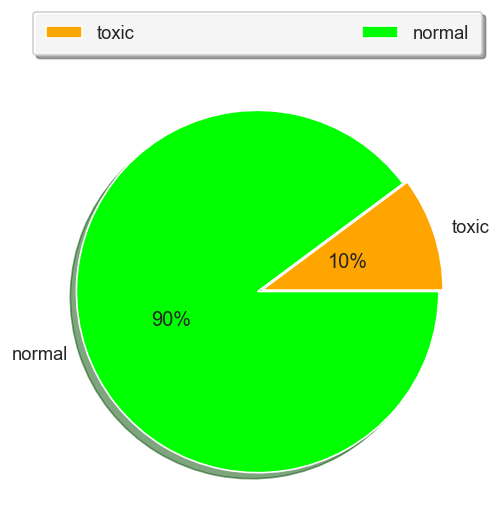

In [18]:
#Pie plot to show the percentage of toxic and normal comment
values=[cmt.shape[0]-cmt.normal.sum(),cmt.normal.sum()]
label=['toxic','normal']
exp=(0.025,0)
clr=('orange','lime')
plt.figure(figsize=(5,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=values,explode=exp,labels=label,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=1)
plt.legend(fancybox=True, framealpha=0.9, shadow=True, borderpad=0.7,bbox_to_anchor=(0., 1.02, 1., .102),ncol=2, mode="expand", borderaxespad=0.1)
plt.show()

In [19]:
#COUNT OF DIFFERENT LABELS
x=cmt.iloc[:,2:-1].sum()
x

highly_malignant      1595
rude                  8449
threat                 478
abuse                 7877
loathe                1405
normal              143346
dtype: int64

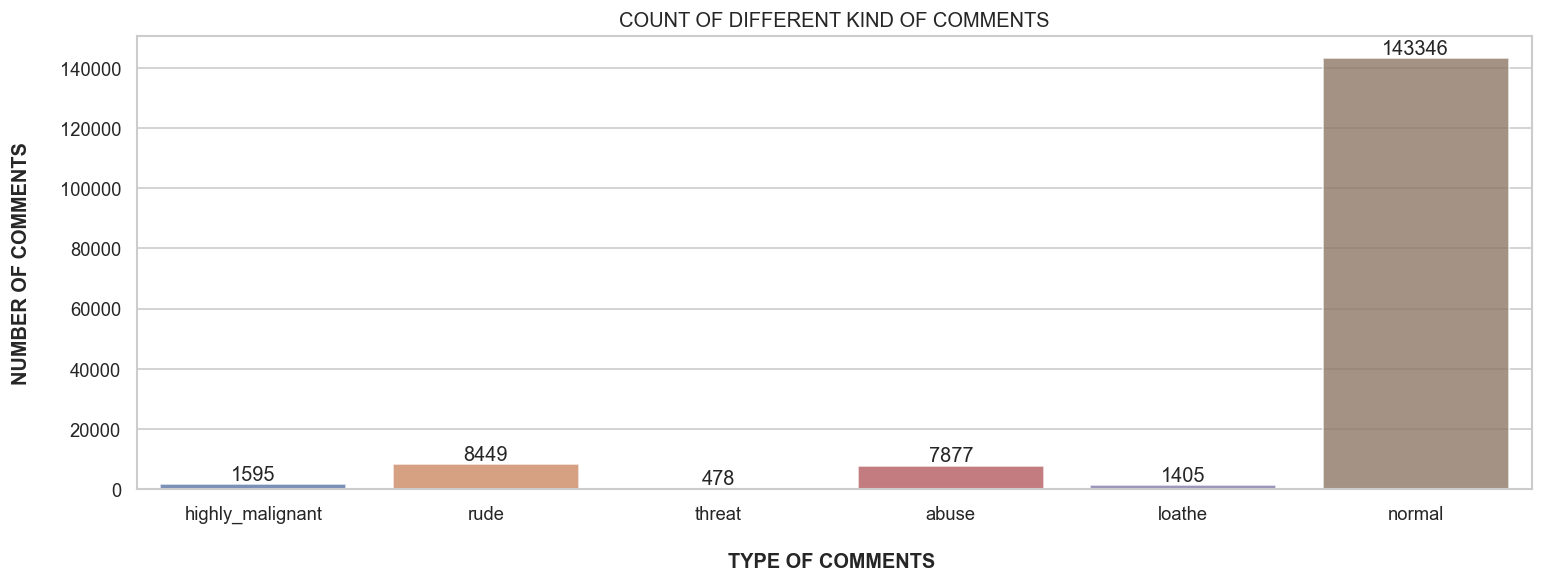

In [20]:
#COUNT OF LABELS
x=cmt.iloc[:,2:-1].sum() #not including comment_text and raw length column
plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("COUNT OF DIFFERENT KIND OF COMMENTS")
plt.ylabel('NUMBER OF COMMENTS\n', fontsize=12,weight='bold')
plt.xlabel('\nTYPE OF COMMENTS ', fontsize=12,weight='bold')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [21]:
#CHECKING THE COUNT OF COMMENTS WITH 1 OR MORE THAN 1 LABELS
summation=cmt.iloc[:,2:-1].sum(axis=1) #not including comment_text and raw length column
vc=summation.value_counts()
vc

1    147303
0      5666
2      4406
3      1780
4       385
5        31
dtype: int64

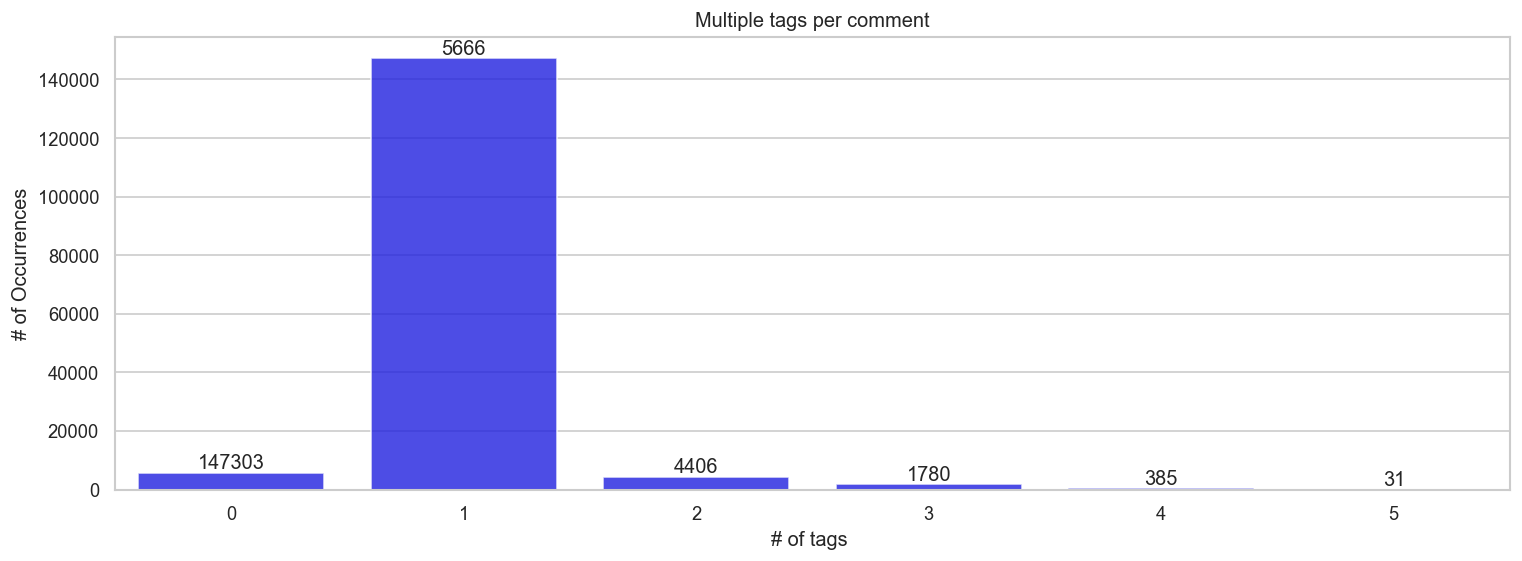

In [22]:
#PLOTTING NUMBERS OF COMMENTS WITH 1 OR MORE THAN 1 LABELS

plt.figure(figsize=(15,5),dpi=120)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
ax=sns.barplot(x=vc.index, y=vc.values, alpha=0.8,color='blue')
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
rects = ax.patches
labels = vc.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [23]:
cmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   comment_text      159571 non-null  object
 1   malignant         159571 non-null  int64 
 2   highly_malignant  159571 non-null  int64 
 3   rude              159571 non-null  int64 
 4   threat            159571 non-null  int64 
 5   abuse             159571 non-null  int64 
 6   loathe            159571 non-null  int64 
 7   normal            159571 non-null  int64 
 8   raw length        159571 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 11.0+ MB


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 1.2+ MB


In [25]:
cmt.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321,394.138847
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226,590.725381
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,96.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,205.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,436.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5000.000000


In [26]:
stopwords=['i','me','my','myself','we','our','ours','ourselves','you',"you're","you've","you'll","you'd",'yo','nothin','from','bein','u','ok','yup','youve',
           'your','yours','yourself','yourselves','he','him','his','himself','she',"she's",'her','hers','ur','mlm','nbfc',"he's",'ip','ja',"there's",'tyme','yep'
           'herself','it',"it's",'its','itself','they','them','their','theirs','themselves','what','which','lol','lool','fwiw','argh',"dont","i'll",'utc','too','y','u','r','doesnt'
           'who','whom','this','that',"that'll",'these','how','these','those','am','is','are','was','were','oh','hay','thanks','ty','wc','ha','hi','d','re','ll','there','someone','say',
           'be','been','being','have','has','had','having','do','does','did','done','doing','a','an','the','even','aww','bye!','bye','e','f','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against',
           'between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how',
           'all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don',"don't",'should',"should've",'now','d','ll','m',
           'o','re','ve','y','ain','aren',"aren't",'couldn',"couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'ma','mightn',"mightn't",'mustn',"mustn't",'needn',
           "needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't", 'looked', "what's",'although','upright','bit','right','state',"i've",'much','more',
           "there's","You've",'got',"i'd",'everything','true','yes','moreover','would','could','like','mr.','but',"i'm",'able','back','get','still','ought','perhaps','without','away','onto','ive','let',
          'must','see','went','saw','many','whats','id','let','day','never','yet','im','go','thatll','theyre','came','youll','come','word','noone',"mrs.","now!","then?",'mr','ve','Â Â','january','days','february','march','april','may','june','july','august','september',
           'october','november','december','everyone','hey','ok','okay','cant','bbq','let','thats','also','time','name','oh','said','asked','anyone','however','wow','daww']

In [27]:
#CREATING A FUNCTION TO PERFORM ASERIES OF OPERATIONS

def preprocess(text):
    processed=[]
    lower=text.lower().replace(r'\n'," ").replace(r'^.+@[^\.].*\.[a-z]{2,}$',' ').replace(r'^http://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',' ')
    #converting to lower case and replacing mail id,links by white space
    
    text=lower.replace(r'\s+', ' ').replace(r'\d+(\.\d+)?', ' ')
    #removing \n,large white space and leading_trailing white spaces, numbers by white space
    
    text=lower.replace(r"[^a-zA-Z]+", " ").replace(r"—"," ").replace(r'“', ' ').replace(r'”',' ').replace('’',' ').replace(r'–',' ').replace('«', ' ').replace('»',' ')
    text=text.replace('®',' ').replace('´',' ').replace('·',' ').replace('½',' ').replace('¾',' ').replace('¤',' ')
    #removing special characters by single white space
    
   
   
    punct=text.translate(str.maketrans('', '', p))  #remove punctuation
    digit=punct.translate(str.maketrans('', '', d))       #remove digits if any
    word= wt(digit, "english")
    
    for i in word:
        if i not in stopwords and len(i)>=3 and len(i)<12:
            lemma=porter().stem(wl().lemmatize(i))
           # lemma=wl().lemmatize(i)
            #stem=porter.stem(lemma)
            processed.append(lemma)
    return (" ".join([x for x in processed])).strip()

In [28]:
#TESTING THE FUNCTION CREATED ABOVE
sample=" As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable information\
on the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - \
are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the \
Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing the\
line a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters \
Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on \
wiki to ""Country where the Rohingya are Persecuted"".\nRather, a brief mention of where the Rohingyas reside should be placed if desired\
on the main article on Rakhine state - albeit short and concise, not dump an entire list of names copied directly from some publication.\nWith\
all due respect, this article should be deleted."

print("Original Document: \n",sample)

processed=[]
for word in sample.split(' '):
    processed.append(word)
print('\n',processed)
print("\n\nTokenized and lemmatized document: \n")
print(preprocess(sample))

Original Document: 
  As much as human rights and ethnic rights should be respected, spray painting every possible detail of unverifiable informationon the Rohingya, and getting around the verification by claiming that the information was destroyed by an interested party - are not valid reasons for having a list of villages where a certain group of people live. There is already a lot of articles on the Arakanese people and state that have no concern of the Rohingya but include them for the sake of brotherly respect - this is pushing theline a bit far. Rohingyas should be treated fairly - I do not contest that. But articles like this one - are pure self-pitying and clutters Wikipedia with absolutely useless information. I wonder when will somebody change the name of the article on Burma/Myanmar on wiki to Country where the Rohingya are Persecuted.
Rather, a brief mention of where the Rohingyas reside should be placed if desiredon the main article on Rakhine state - albeit short and conc

In [29]:
%%time
clean = []

for i in cmt.comment_text:
    clean.append(preprocess(i))

Wall time: 3min 5s


In [30]:
print("Length of cleaned text=\t",len(clean))
print(clean[37])

Length of cleaned text=	 159571
pretti warren region born glen fall hospit includ sure qualifi glen fall nativ rachel ray believ actual town lake luzern preced unsign comment ad


In [31]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : clean })
cmt['comment']= processed

cmt['len of cleaned comment']=cmt['comment'].str.len().astype('int64')
cmt.head(15)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explan edit made usernam hardcor metallica fan...,141
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingli stuck talk,44
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,man realli tri edit war guy constantli remov r...,114
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,make real suggest improv wonder section statis...,250
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,sir hero chanc rememb page,26
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65,well use tool well talk,23
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44,cocksuck piss around work,25
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1,115,vandal matt shirvington articl revert pleas ban,47
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1,472,sorri nonsens offens anyway intend write anyth...,201
9,alignment on this subject and which are contra...,0,0,0,0,0,0,1,70,align subject contrari dulithgow,32


In [32]:
print('Original Length = ',cmt['raw length'].sum())
print('Clean Length =  ', cmt['len of cleaned comment'].sum())
print('Total Reduction = ',cmt['raw length'].sum()-cmt['len of cleaned comment'].sum())

Original Length =  62893130
Clean Length =   29977753
Total Reduction =  32915377


In [33]:
%%time
comments = []

for i in test.comment_text:
    comments.append(preprocess(i))

Wall time: 2min 45s


In [34]:
#USING THE EXTRACTED FEATURE AS ''comment" also adding an extra column to represent the length of string of the cleaned comments
processed = pd.DataFrame({'comment' : comments })
test['comment']= processed
test.head(5)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl


#### WORD CLOUDS

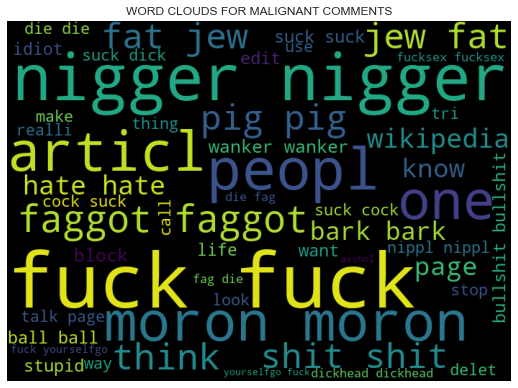

In [35]:
malignant = cmt['comment'][cmt['malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR MALIGNANT COMMENTS')
plt.show()

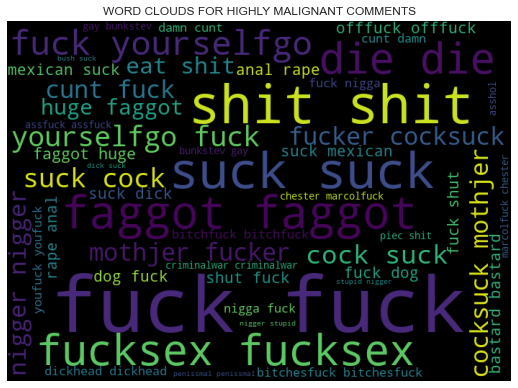

In [36]:
highly_malignant = cmt['comment'][cmt['highly_malignant']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(highly_malignant))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR HIGHLY MALIGNANT COMMENTS')
plt.show()

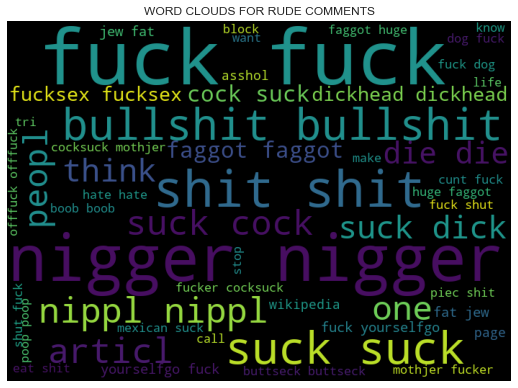

In [37]:
rude = cmt['comment'][cmt['rude']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(rude))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR RUDE COMMENTS')
plt.show()

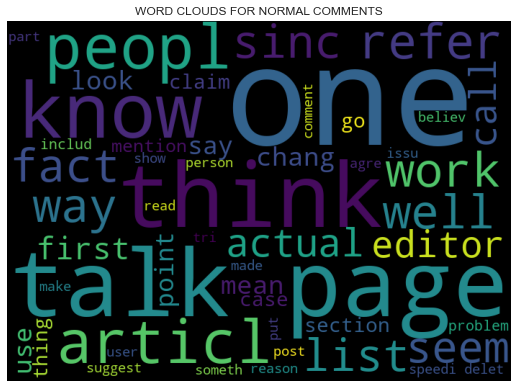

In [38]:
normal = cmt['comment'][cmt['normal']==1]
wordcloud = WordCloud(width=700,height=500,background_color='black',max_words=50).generate(' '.join(normal))
plt.figure(figsize = (7,5), facecolor = 'white', edgecolor='blue') 
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('WORD CLOUDS FOR NORMAL COMMENTS')
plt.show()

# MODELLING 

In [39]:
cmt.sample(4)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,normal,raw length,comment,len of cleaned comment
135981,Old AFDs \n\nSeems to have stopped working. Th...,0,0,0,0,0,0,1,111,old afd seem stop work thought might appreci m...,61
46806,charlene hendricks \n\ncharlene hendricks was ...,0,0,0,0,0,0,1,147,charlen hendrick charlen hendrick born african...,64
59844,"""\n\nShe actually appeared in 3 episodes of """"...",0,0,0,0,0,0,1,414,actual appear episod motherhood freakin websit...,164
19494,)\\n\nWikipedia is collapsing under its own we...,0,0,0,0,0,0,1,477,wikipedia collaps weight user public ace dummi...,194


In [40]:
X=cmt.comment
y=cmt.iloc[:,1:-3]

In [41]:
X.head(4)

0    explan edit made usernam hardcor metallica fan...
1         match background colour seemingli stuck talk
2    man realli tri edit war guy constantli remov r...
3    make real suggest improv wonder section statis...
Name: comment, dtype: object

In [42]:
y.head(4)

,malignant,highly_malignant,rude,threat,abuse,loathe,normal
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1


In [43]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))

In [44]:
x=tfidf.fit_transform(X).toarray()

In [45]:
#CHECKING THE SELECTED FEATURE NAMES
tfidf.get_feature_names()[1:9]

['abandon', 'abc', 'abid', 'abil', 'aborigin', 'abort', 'abraham', 'abroad']

In [46]:
x_train,x_test,y_train,y_test=tts(x,y,test_size=0.30,random_state=95)

In [47]:
print('shape of x_train:',x_train.shape,'\nshape of x_test:',x_test.shape)

print('shape of y_train:',y_train.shape,'\nshape of y_test:',y_test.shape)

shape of x_train: (111699, 10000) 
shape of x_test: (47872, 10000)
shape of y_train: (111699, 7) 
shape of y_test: (47872, 7)


In [48]:
labels=['malignant','highly_malignant','rude','threat','abuse','loathe','normal']

### LOGISTIC REGRESSION

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9560703542780749

F1 score: 0.7239070500196929

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     43299
           1       0.91      0.60      0.72      4573

    accuracy                           0.96     47872
   macro avg       0.93      0.80      0.85     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.9057161629434954

RECALL:
 0.6028865077629565

MEAN SQUARED ERROR:
 0.043929645721925134

ROOT MEAN SQ. ERROR:
 0.20959400211343152

LOG_LOSS: 1.5172810044067442

AUC_ROC Score:
 0.7981290895820717

TPR: [0.         0.00662833 1.        ] 
FPR: [0.         0.60288651 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



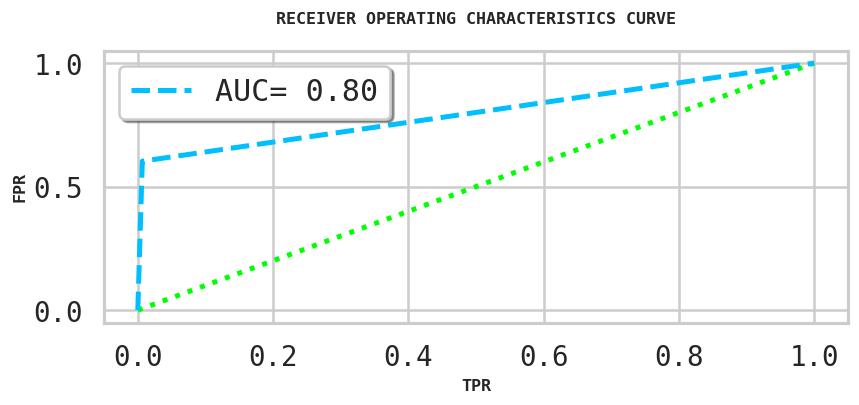





	____________________________________________CONFUSION MATRIX___________________________________________



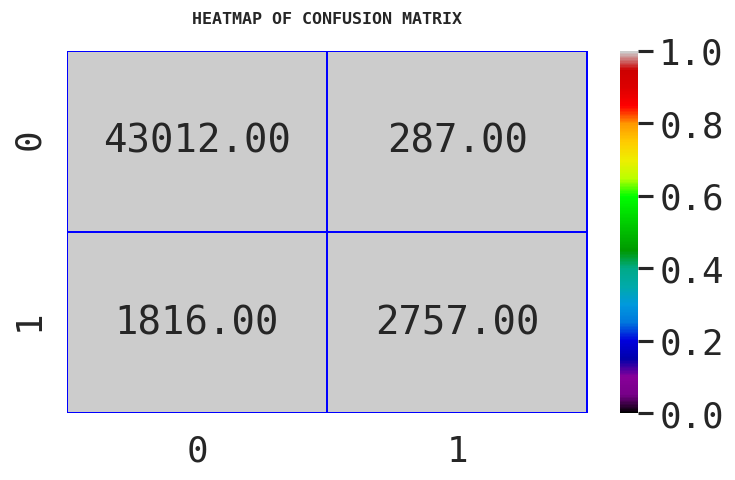



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9903492647058824

F1 score: 0.26666666666666666

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47425
           1       0.46      0.19      0.27       447

    accuracy                           0.99     47872
   macro avg       0.73      0.59      0.63     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.45901639344262296

RECALL:
 0.18791946308724833

MEAN SQUARED ERROR:
 0.009650735294117647

ROOT MEAN SQ. ERROR:
 0.09823815599917197

LOG_LOSS: 0.33332624194924737

AUC_ROC Score:
 0.5929159782489484

TPR: [0.         0.00208751 1.        ] 
FPR: [0.         0.18791946 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



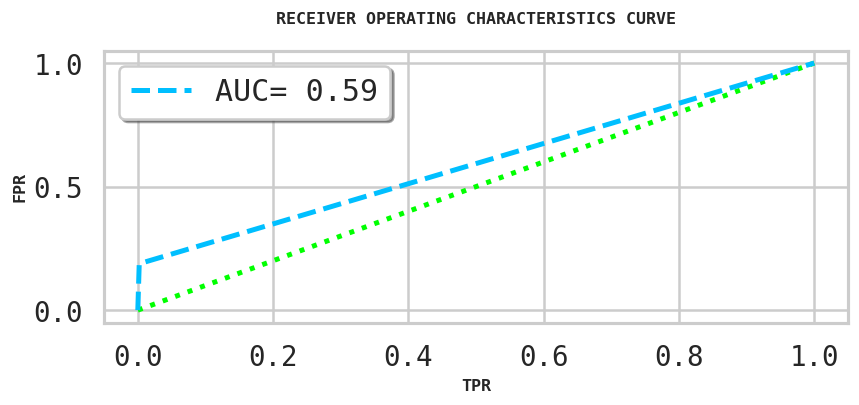





	____________________________________________CONFUSION MATRIX___________________________________________



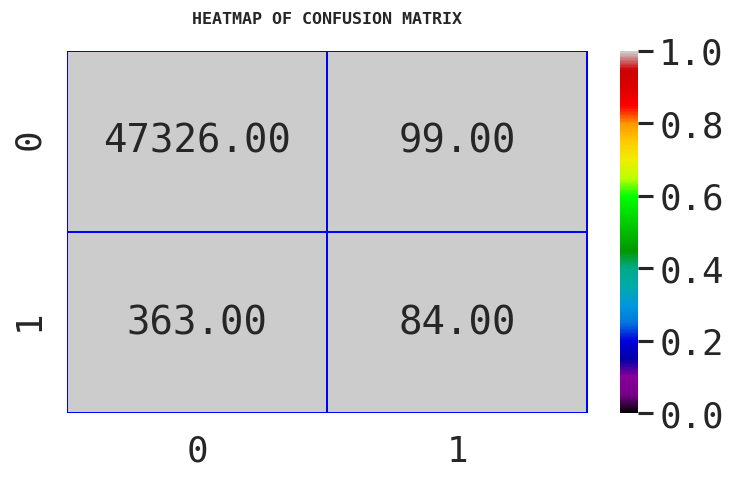



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9773980614973262

F1 score: 0.7460093896713614

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     45359
           1       0.91      0.63      0.75      2513

    accuracy                           0.98     47872
   macro avg       0.94      0.81      0.87     47872
weighted avg       0.98      0.98      0.98     47872


PRECISION:
 0.909559244419004

RECALL:
 0.6323119777158774

MEAN SQUARED ERROR:
 0.022601938502673797

ROOT MEAN SQ. ERROR:
 0.15033941100946815

LOG_LOSS: 0.7806459390810363

AUC_ROC Score:
 0.8144143278865769

TPR: [0.         0.00348332 1.        ] 
FPR: [0.         0.63231198 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



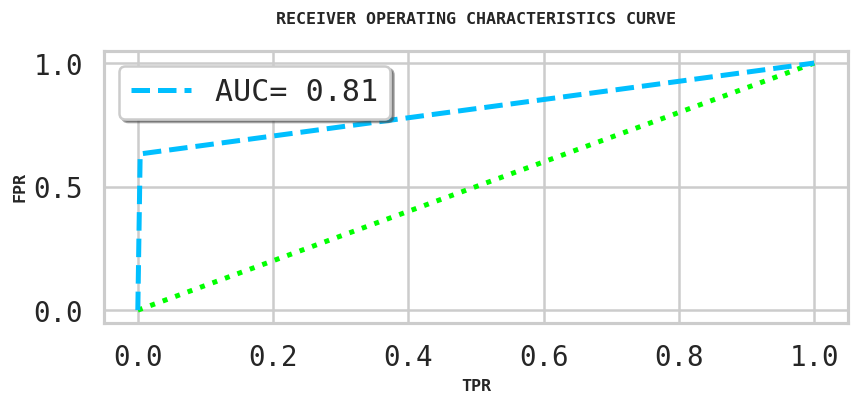





	____________________________________________CONFUSION MATRIX___________________________________________



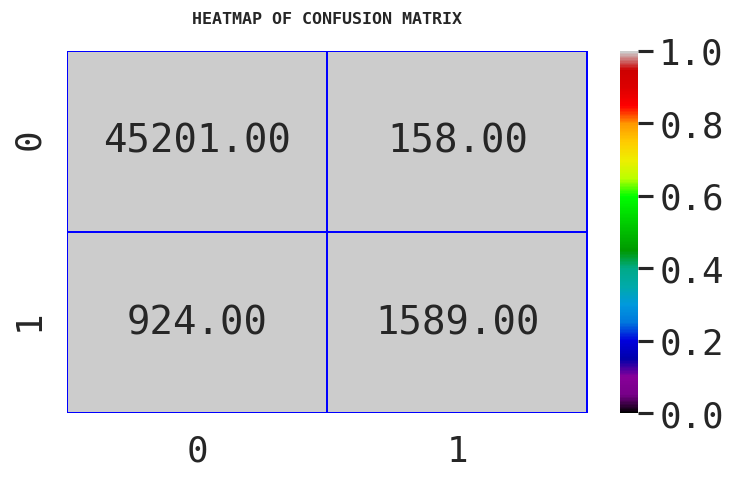



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9972426470588235

F1 score: 0.12000000000000001

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.60      0.07      0.12       135

    accuracy                           1.00     47872
   macro avg       0.80      0.53      0.56     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.6

RECALL:
 0.06666666666666667

MEAN SQUARED ERROR:
 0.0027573529411764708

ROOT MEAN SQ. ERROR:
 0.05251050315105037

LOG_LOSS: 0.09523569689406831

AUC_ROC Score:
 0.5332704889987501

TPR: [0.00000000e+00 1.25688669e-04 1.00000000e+00] 
FPR: [0.         0.06666667 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



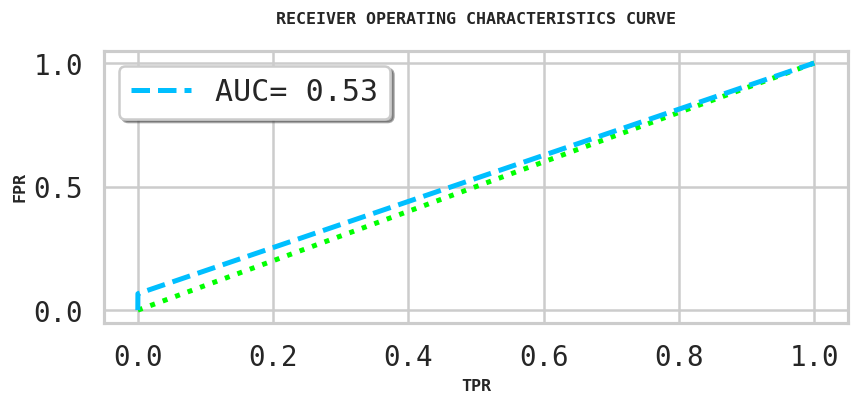





	____________________________________________CONFUSION MATRIX___________________________________________



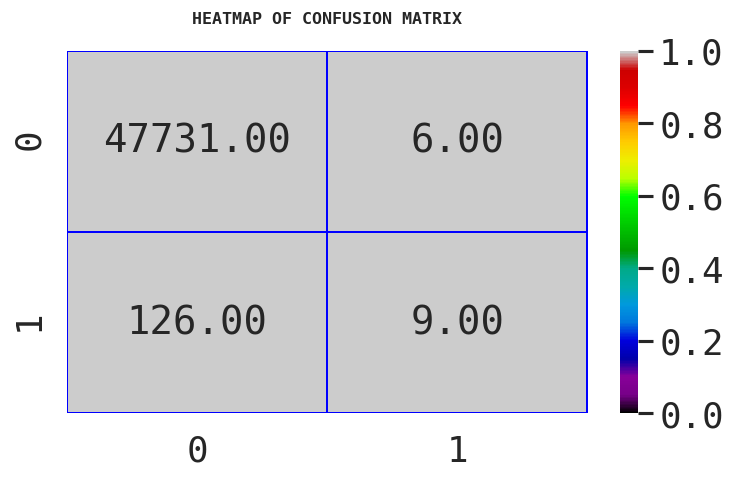



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9701286764705882

F1 score: 0.6226912928759895

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     45531
           1       0.81      0.50      0.62      2341

    accuracy                           0.97     47872
   macro avg       0.89      0.75      0.80     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.8143547273982057

RECALL:
 0.5040580948312687

MEAN SQUARED ERROR:
 0.029871323529411766

ROOT MEAN SQ. ERROR:
 0.17283322461092882

LOG_LOSS: 1.031723457061143

AUC_ROC Score:
 0.7490750160963134

TPR: [0.         0.00590806 1.        ] 
FPR: [0.         0.50405809 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



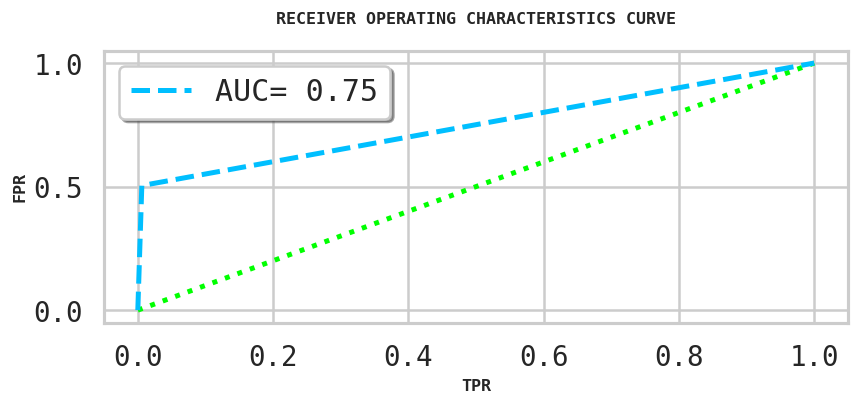





	____________________________________________CONFUSION MATRIX___________________________________________



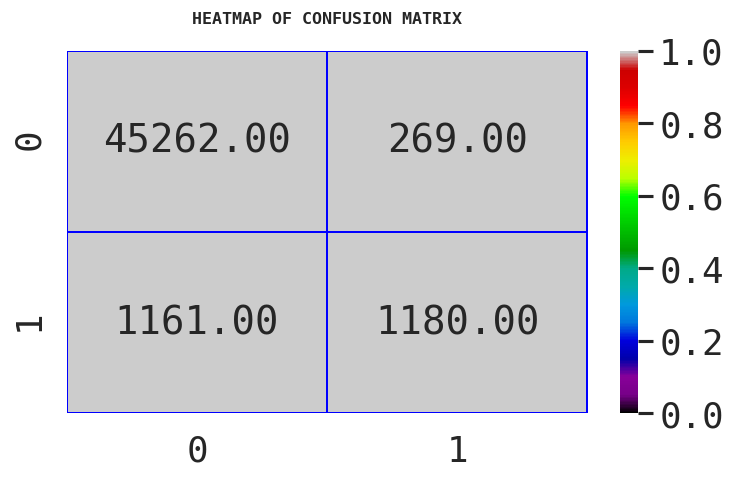



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.991915942513369

F1 score: 0.2656546489563567

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.68      0.17      0.27       424

    accuracy                           0.99     47872
   macro avg       0.84      0.58      0.63     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.6796116504854369

RECALL:
 0.1650943396226415

MEAN SQUARED ERROR:
 0.008084057486631015

ROOT MEAN SQ. ERROR:
 0.08991138685745546

LOG_LOSS: 0.2792140050874347

AUC_ROC Score:
 0.5821994206965003

TPR: [0.0000000e+00 6.9549823e-04 1.0000000e+00] 
FPR: [0.         0.16509434 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



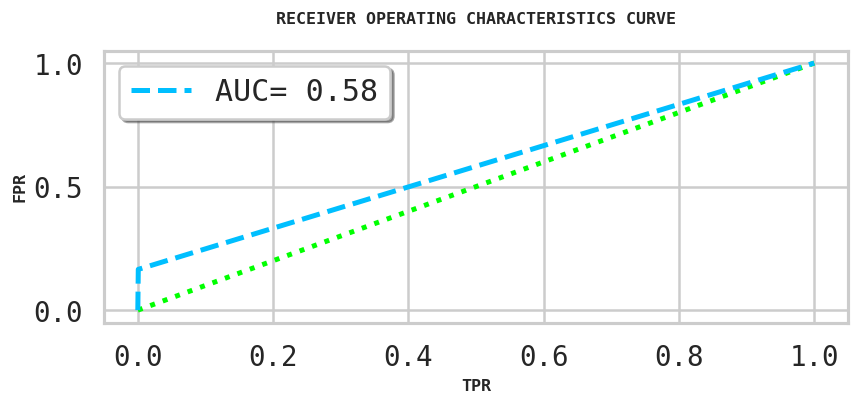





	____________________________________________CONFUSION MATRIX___________________________________________



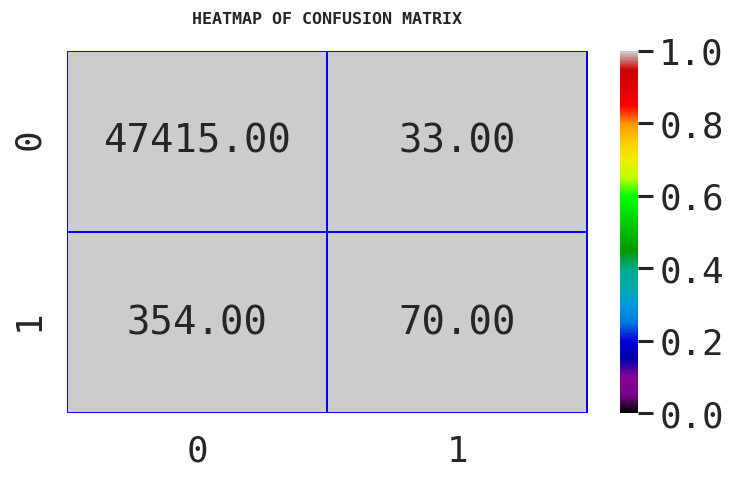



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9554227941176471

F1 score: 0.9756531660011409

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      4844
           1       0.96      0.99      0.98     43028

    accuracy                           0.96     47872
   macro avg       0.94      0.80      0.86     47872
weighted avg       0.95      0.96      0.95     47872


PRECISION:
 0.958226883600018

RECALL:
 0.9937250162684763

MEAN SQUARED ERROR:
 0.04457720588235294

ROOT MEAN SQ. ERROR:
 0.21113314728472396

LOG_LOSS: 1.5396732803381794

AUC_ROC Score:
 0.8044595353844446

TPR: [0.         0.38480595 1.        ] 
FPR: [0.         0.99372502 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



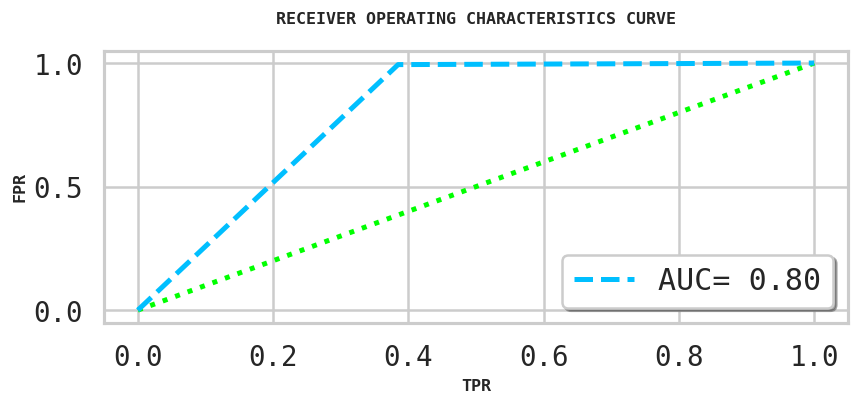





	____________________________________________CONFUSION MATRIX___________________________________________



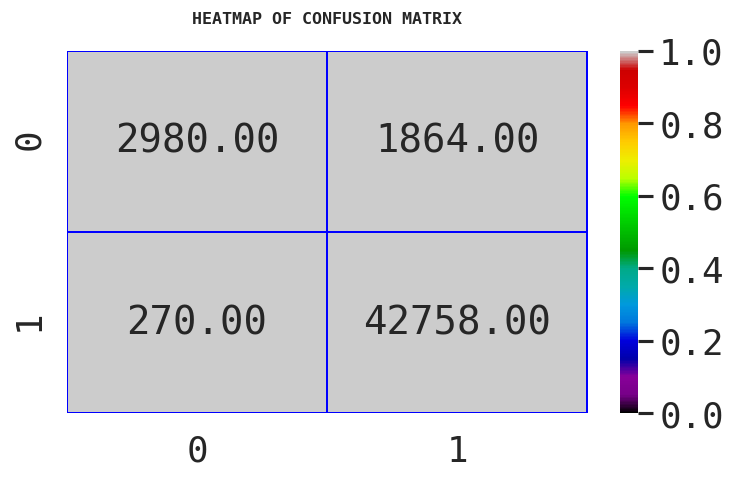

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.723907,0.956070,0.905716,0.602887,0.209594,0.043930,0.798129,1.517281
1,highly_malignant,0.266667,0.990349,0.459016,0.187919,0.098238,0.009651,0.592916,0.333326
2,rude,0.746009,0.977398,0.909559,0.632312,0.150339,0.022602,0.814414,0.780646
3,threat,0.120000,0.997243,0.600000,0.066667,0.052511,0.002757,0.533270,0.095236
4,abuse,0.622691,0.970129,0.814355,0.504058,0.172833,0.029871,0.749075,1.031723
5,loathe,0.265655,0.991916,0.679612,0.165094,0.089911,0.008084,0.582199,0.279214
6,normal,0.975653,0.955423,0.958227,0.993725,0.211133,0.044577,0.804460,1.539673


In [49]:
LogReg_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]

for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    LogReg_pipeline.fit(x_train, y_train[category])
    pred = LogReg_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

logi_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
logi_results.style.set_properties(**{'background-color':'midnightblue','color': 'lime','border-color': 'darkorange'})                                

### PASSIVE AGGRESSIVE CLASSIFIER

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.9462942847593583

F1 score: 0.7186166137681953

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97     43299
           1       0.72      0.72      0.72      4573

    accuracy                           0.95     47872
   macro avg       0.84      0.84      0.84     47872
weighted avg       0.95      0.95      0.95     47872


PRECISION:
 0.7193251533742331

RECALL:
 0.7179094686201618

MEAN SQUARED ERROR:
 0.05370571524064171

ROOT MEAN SQ. ERROR:
 0.23174493573893198

LOG_LOSS: 1.854951086138525

AUC_ROC Score:
 0.8441622448761448

TPR: [0.         0.02958498 1.        ] 
FPR: [0.         0.71790947 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



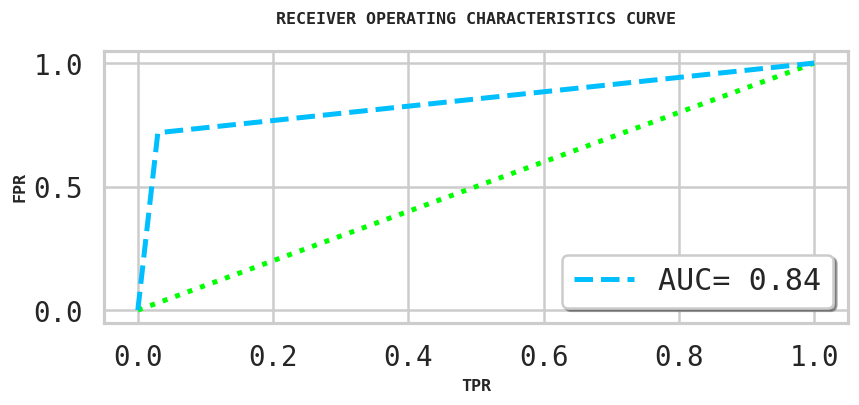





	____________________________________________CONFUSION MATRIX___________________________________________



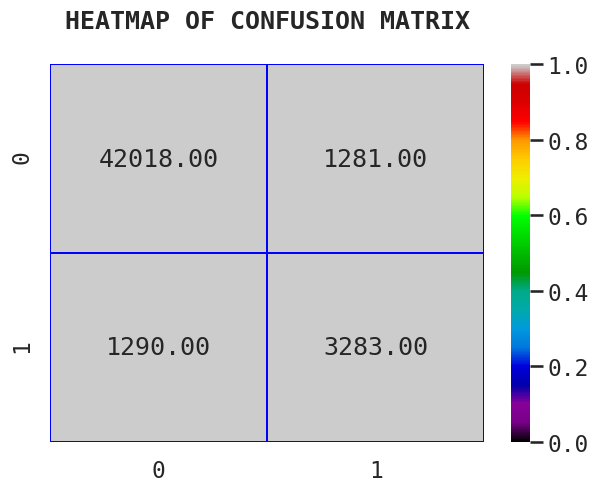



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9896390374331551

F1 score: 0.30337078651685395

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47425
           1       0.41      0.24      0.30       447

    accuracy                           0.99     47872
   macro avg       0.70      0.62      0.65     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.4075471698113208

RECALL:
 0.24161073825503357

MEAN SQUARED ERROR:
 0.01036096256684492

ROOT MEAN SQ. ERROR:
 0.10178881356438398

LOG_LOSS: 0.35785759167513964

AUC_ROC Score:
 0.619150124003637

TPR: [0.         0.00331049 1.        ] 
FPR: [0.         0.24161074 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



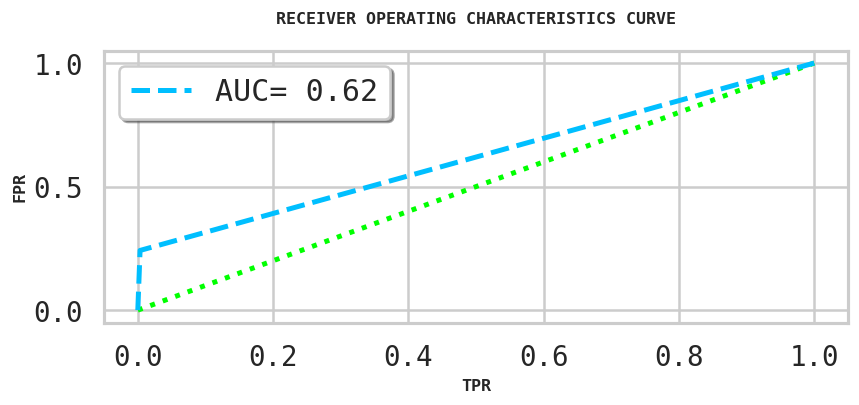





	____________________________________________CONFUSION MATRIX___________________________________________



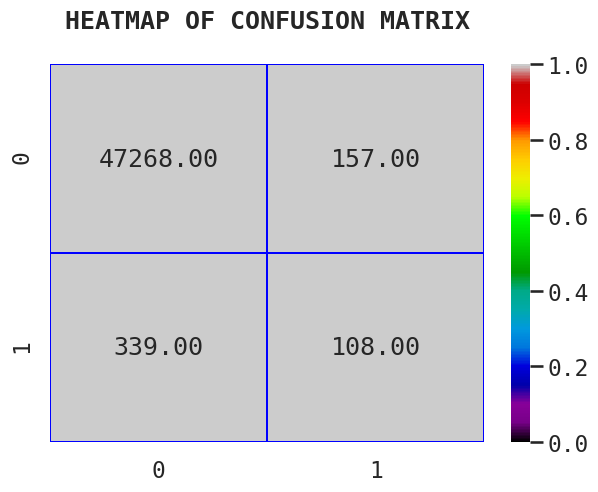



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9763536096256684

F1 score: 0.7458464301751234

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     45359
           1       0.86      0.66      0.75      2513

    accuracy                           0.98     47872
   macro avg       0.92      0.83      0.87     47872
weighted avg       0.97      0.98      0.97     47872


PRECISION:
 0.8557444616177228

RECALL:
 0.6609629924393156

MEAN SQUARED ERROR:
 0.02364639037433155

ROOT MEAN SQ. ERROR:
 0.15377382863911385

LOG_LOSS: 0.8167220664755888

AUC_ROC Score:
 0.8273950084223077

TPR: [0.         0.00617298 1.        ] 
FPR: [0.         0.66096299 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



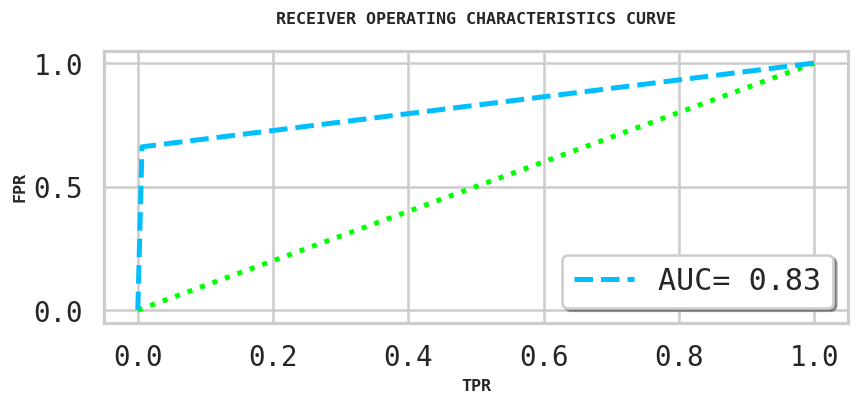





	____________________________________________CONFUSION MATRIX___________________________________________



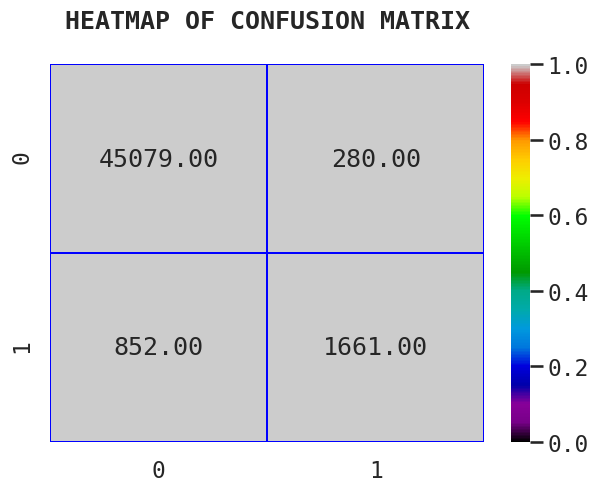



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9972217580213903

F1 score: 0.19393939393939394

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.53      0.12      0.19       135

    accuracy                           1.00     47872
   macro avg       0.77      0.56      0.60     47872
weighted avg       1.00      1.00      1.00     47872


PRECISION:
 0.5333333333333333

RECALL:
 0.11851851851851852

MEAN SQUARED ERROR:
 0.0027782419786096255

ROOT MEAN SQ. ERROR:
 0.0527090312812674

LOG_LOSS: 0.09595731230964219

AUC_ROC Score:
 0.5591126224785651

TPR: [0.00000000e+00 2.93273561e-04 1.00000000e+00] 
FPR: [0.         0.11851852 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



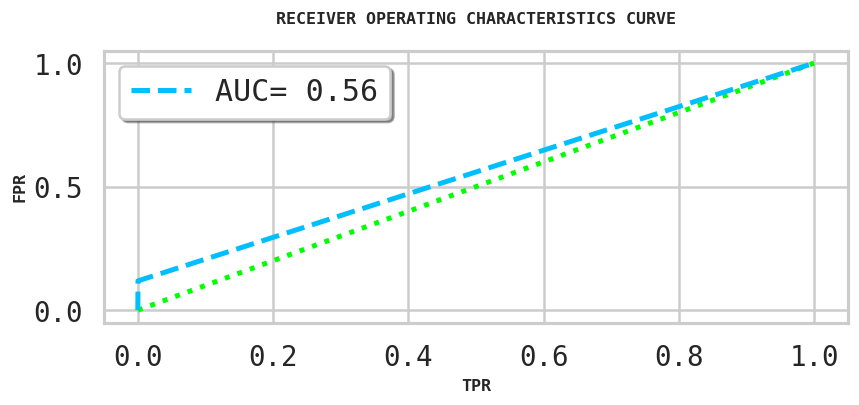





	____________________________________________CONFUSION MATRIX___________________________________________



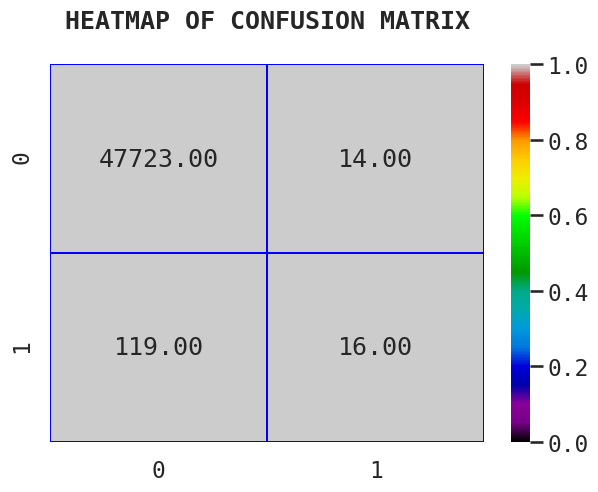



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9686037767379679

F1 score: 0.626212384978861

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     45531
           1       0.75      0.54      0.63      2341

    accuracy                           0.97     47872
   macro avg       0.86      0.76      0.80     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.7494047619047619

RECALL:
 0.5378043571123452

MEAN SQUARED ERROR:
 0.031396223262032084

ROOT MEAN SQ. ERROR:
 0.1771897944635415

LOG_LOSS: 1.0843941667795145

AUC_ROC Score:
 0.7642789548184994

TPR: [0.         0.00924645 1.        ] 
FPR: [0.         0.53780436 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



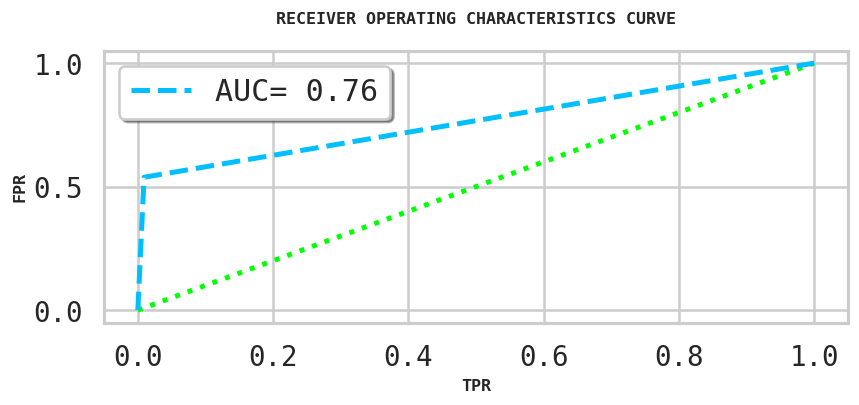





	____________________________________________CONFUSION MATRIX___________________________________________



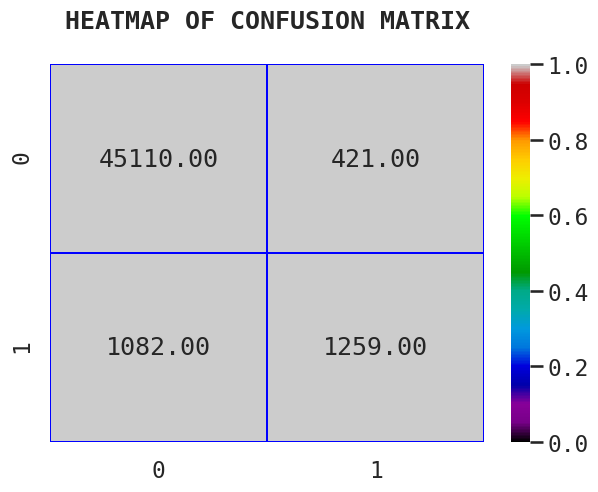



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9916861631016043

F1 score: 0.3538961038961039

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     47448
           1       0.57      0.26      0.35       424

    accuracy                           0.99     47872
   macro avg       0.78      0.63      0.67     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.5677083333333334

RECALL:
 0.25707547169811323

MEAN SQUARED ERROR:
 0.008313836898395722

ROOT MEAN SQ. ERROR:
 0.0911802440136882

LOG_LOSS: 0.28715113995156255

AUC_ROC Score:
 0.6276630941360234

TPR: [0.         0.00174928 1.        ] 
FPR: [0.         0.25707547 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



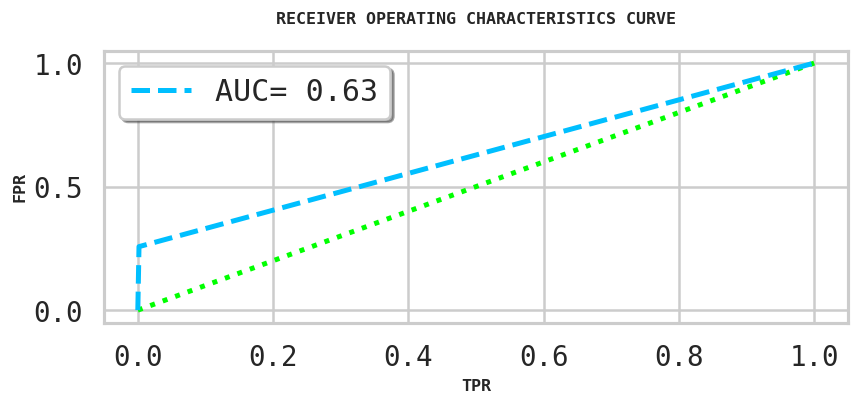





	____________________________________________CONFUSION MATRIX___________________________________________



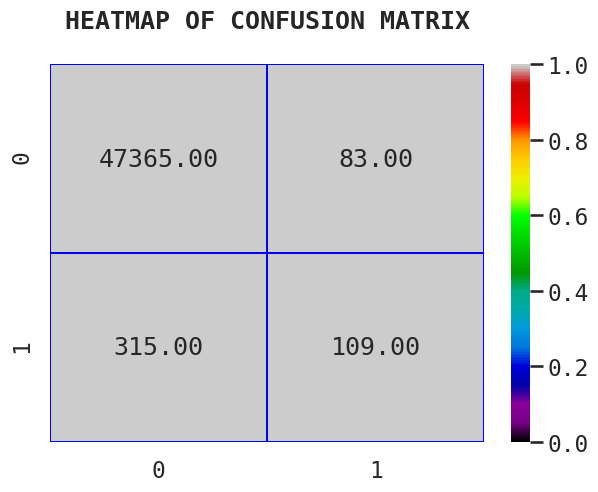



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9483622994652406

F1 score: 0.9713557358053303

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      4844
           1       0.97      0.97      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.86      0.85      0.85     47872
weighted avg       0.95      0.95      0.95     47872


PRECISION:
 0.9686171196154557

RECALL:
 0.9741098819373432

MEAN SQUARED ERROR:
 0.051637700534759357

ROOT MEAN SQ. ERROR:
 0.22723930235493894

LOG_LOSS: 1.7835256747478578

AUC_ROC Score:
 0.8468815305640472

TPR: [0.         0.28034682 1.        ] 
FPR: [0.         0.97410988 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



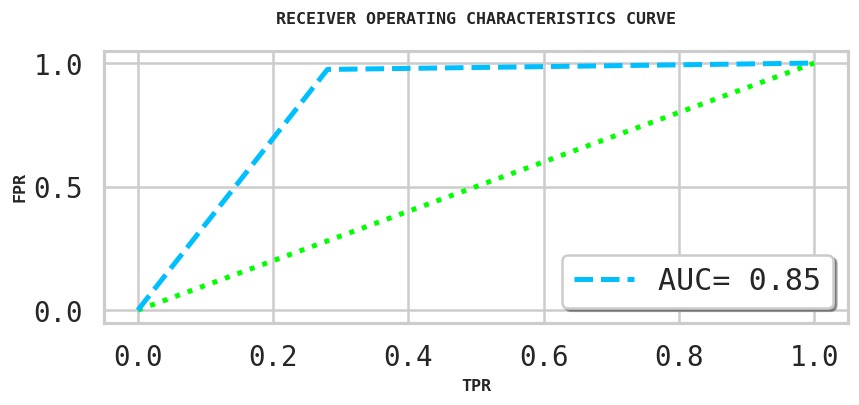





	____________________________________________CONFUSION MATRIX___________________________________________



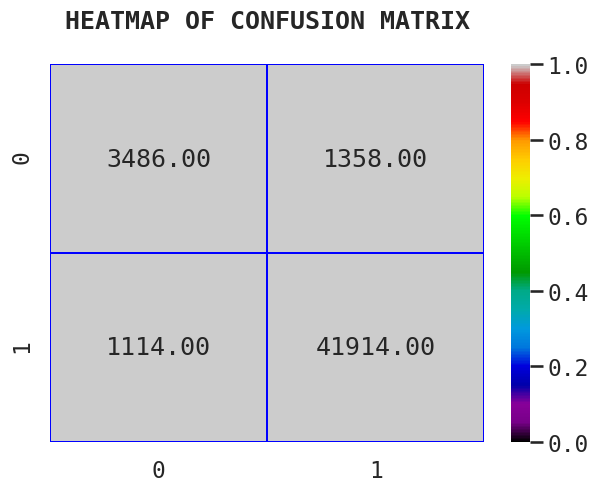

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.718617,0.946294,0.719325,0.717909,0.231745,0.053706,0.844162,1.854951
1,highly_malignant,0.303371,0.989639,0.407547,0.241611,0.101789,0.010361,0.619150,0.357858
2,rude,0.745846,0.976354,0.855744,0.660963,0.153774,0.023646,0.827395,0.816722
3,threat,0.193939,0.997222,0.533333,0.118519,0.052709,0.002778,0.559113,0.095957
4,abuse,0.626212,0.968604,0.749405,0.537804,0.177190,0.031396,0.764279,1.084394
5,loathe,0.353896,0.991686,0.567708,0.257075,0.091180,0.008314,0.627663,0.287151
6,normal,0.971356,0.948362,0.968617,0.974110,0.227239,0.051638,0.846882,1.783526


In [50]:
pac_pipeline = Pipeline([('clf', OneVsRestClassifier(PassiveAggressiveClassifier(), n_jobs=1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    pac_pipeline.fit(x_train, y_train[category])
    pred = pac_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(7,5),dpi=100)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

pac_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
pac_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### MULTINOMIAL NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.947464070855615

F1 score: 0.6406629518502643

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97     43299
           1       0.92      0.49      0.64      4573

    accuracy                           0.95     47872
   macro avg       0.94      0.74      0.81     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9241549876339654

RECALL:
 0.49026897004154824

MEAN SQUARED ERROR:
 0.05253592914438503

ROOT MEAN SQ. ERROR:
 0.22920717515903605

LOG_LOSS: 1.8145297827357862

AUC_ROC Score:
 0.7430097246336982

TPR: [0.         0.00424952 1.        ] 
FPR: [0.         0.49026897 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



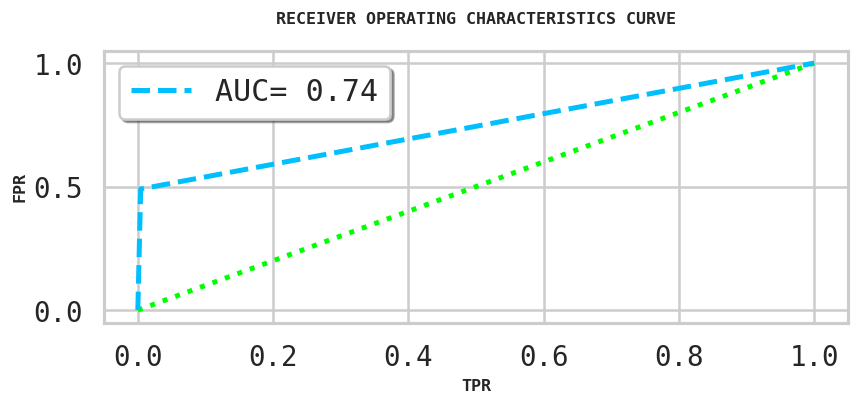





	____________________________________________CONFUSION MATRIX___________________________________________



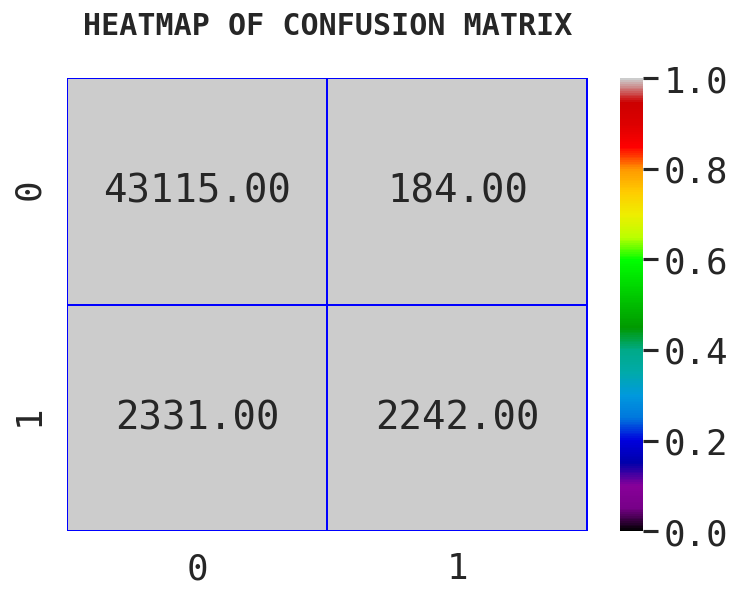



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9891377005347594

F1 score: 0.23753665689149558

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47425
           1       0.34      0.18      0.24       447

    accuracy                           0.99     47872
   macro avg       0.67      0.59      0.62     47872
weighted avg       0.99      0.99      0.99     47872


PRECISION:
 0.3446808510638298

RECALL:
 0.18120805369127516

MEAN SQUARED ERROR:
 0.010862299465240642

ROOT MEAN SQ. ERROR:
 0.10422235588030354

LOG_LOSS: 0.37517310459888564

AUC_ROC Score:
 0.5889804106094753

TPR: [0.         0.00324723 1.        ] 
FPR: [0.         0.18120805 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



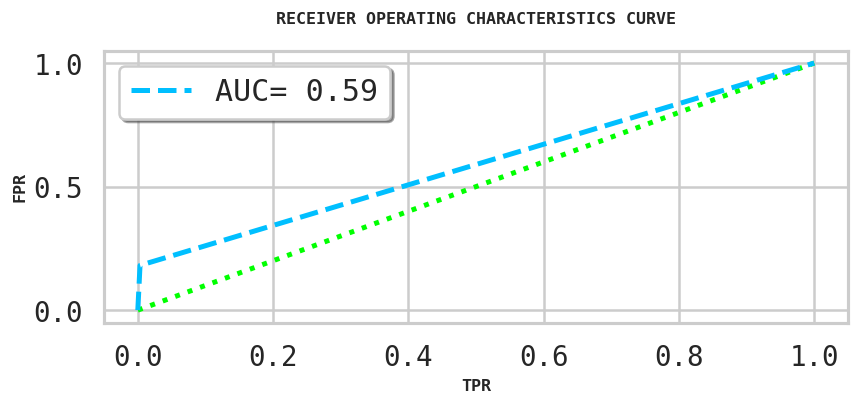





	____________________________________________CONFUSION MATRIX___________________________________________



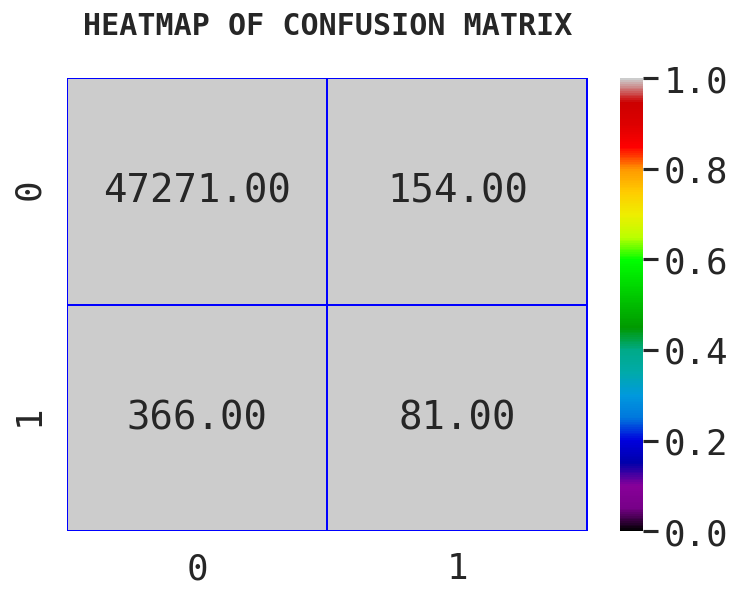



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9704420120320856

F1 score: 0.6398574700941715

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     45359
           1       0.89      0.50      0.64      2513

    accuracy                           0.97     47872
   macro avg       0.93      0.75      0.81     47872
weighted avg       0.97      0.97      0.97     47872


PRECISION:
 0.8877118644067796

RECALL:
 0.5001989653800238

MEAN SQUARED ERROR:
 0.029557987967914437

ROOT MEAN SQ. ERROR:
 0.17192436699873126

LOG_LOSS: 1.0208993928557415

AUC_ROC Score:
 0.7483467985479453

TPR: [0.         0.00350537 1.        ] 
FPR: [0.         0.50019897 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



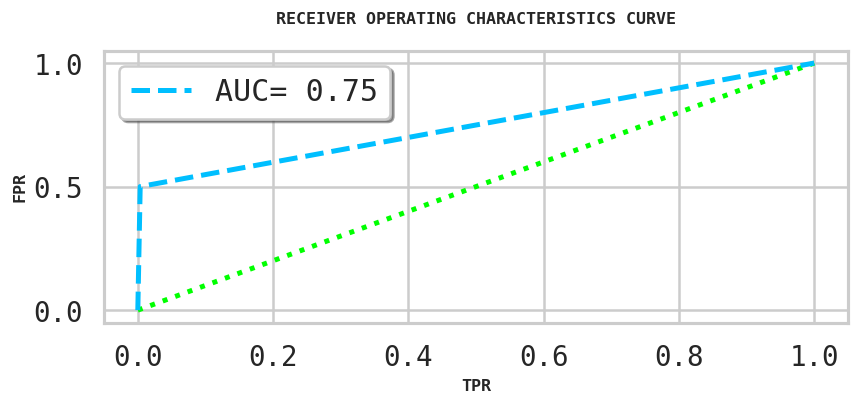





	____________________________________________CONFUSION MATRIX___________________________________________



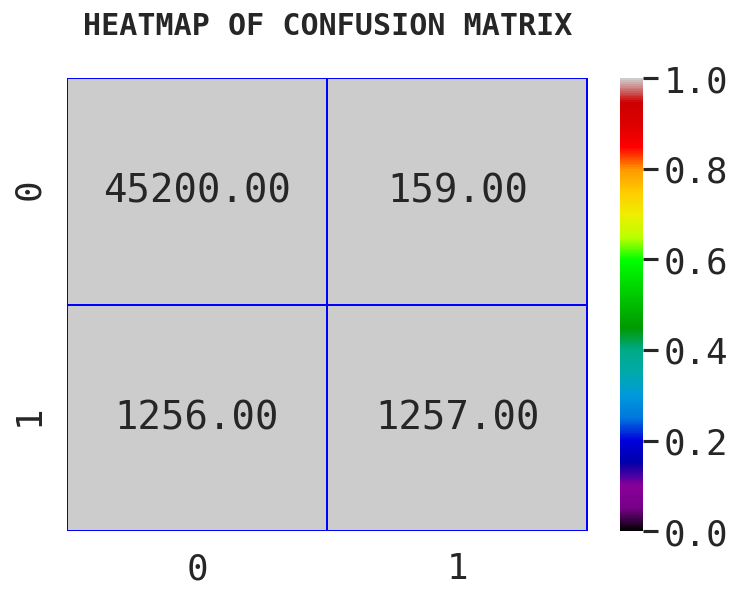



Processing threat
-------------------------------------
ACCURACY SCORE: 0.995550635026738

F1 score: 0.0273972602739726

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47737
           1       0.04      0.02      0.03       135

    accuracy                           1.00     47872
   macro avg       0.52      0.51      0.51     47872
weighted avg       0.99      1.00      1.00     47872


PRECISION:
 0.03571428571428571

RECALL:
 0.022222222222222223

MEAN SQUARED ERROR:
 0.004449364973262032

ROOT MEAN SQ. ERROR:
 0.06670356042417849

LOG_LOSS: 0.15367697483931878

AUC_ROC Score:
 0.5102627125942374

TPR: [0.        0.0016968 1.       ] 
FPR: [0.         0.02222222 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



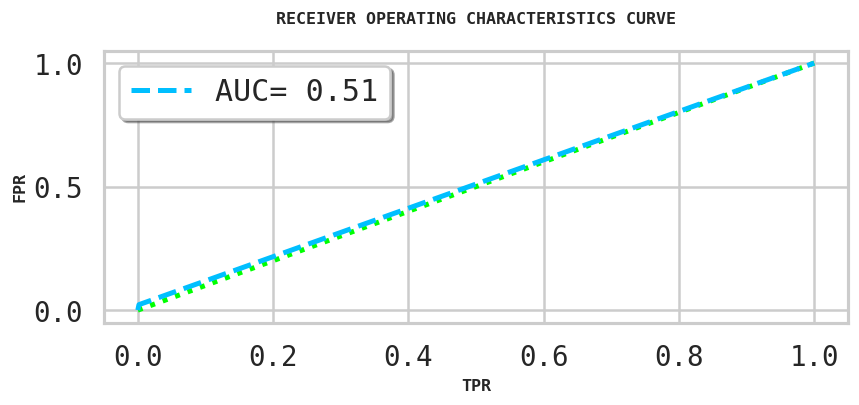





	____________________________________________CONFUSION MATRIX___________________________________________



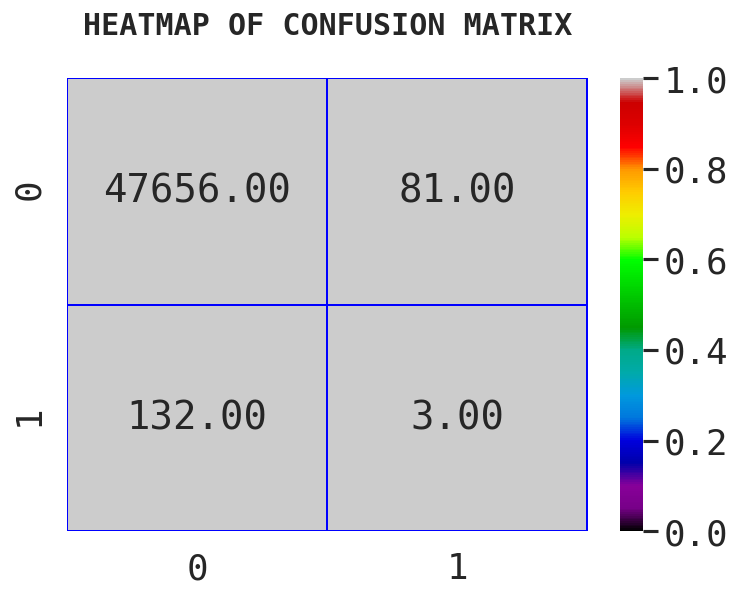



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9663477606951871

F1 score: 0.5424595285430275

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     45531
           1       0.81      0.41      0.54      2341

    accuracy                           0.97     47872
   macro avg       0.89      0.70      0.76     47872
weighted avg       0.96      0.97      0.96     47872


PRECISION:
 0.809322033898305

RECALL:
 0.40794532251174714

MEAN SQUARED ERROR:
 0.033652239304812835

ROOT MEAN SQ. ERROR:
 0.18344546684181878

LOG_LOSS: 1.1623109266716023

AUC_ROC Score:
 0.7015018172155494

TPR: [0.         0.00494169 1.        ] 
FPR: [0.         0.40794532 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



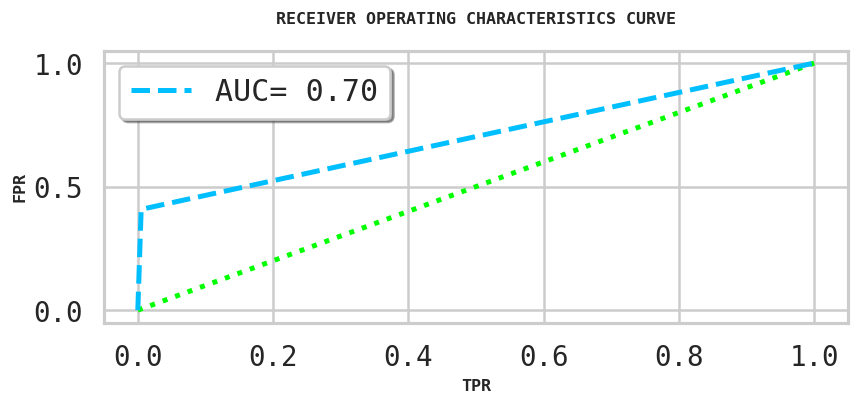





	____________________________________________CONFUSION MATRIX___________________________________________



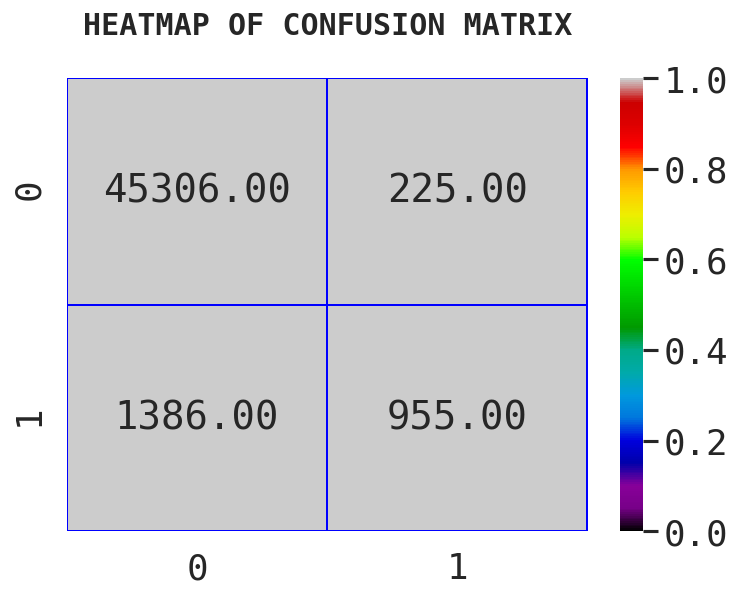



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9892839237967914

F1 score: 0.09203539823008851

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     47448
           1       0.18      0.06      0.09       424

    accuracy                           0.99     47872
   macro avg       0.59      0.53      0.54     47872
weighted avg       0.98      0.99      0.99     47872


PRECISION:
 0.18439716312056736

RECALL:
 0.06132075471698113

MEAN SQUARED ERROR:
 0.010716076203208556

ROOT MEAN SQ. ERROR:
 0.10351848242322989

LOG_LOSS: 0.37012208063781954

AUC_ROC Score:
 0.5294485243826013

TPR: [0.         0.00242371 1.        ] 
FPR: [0.         0.06132075 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



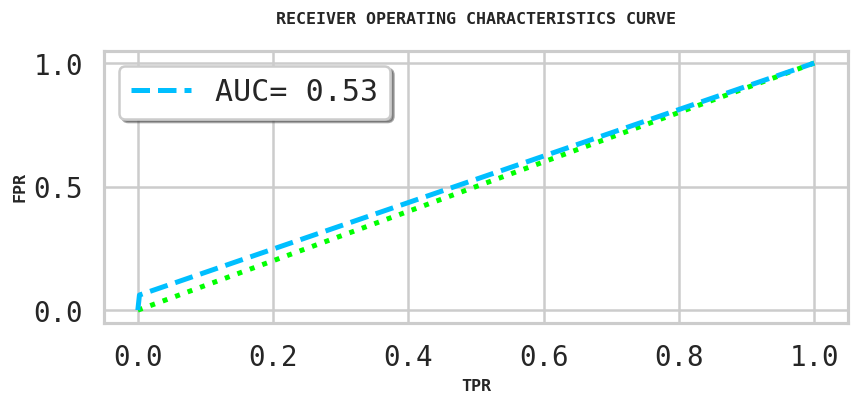





	____________________________________________CONFUSION MATRIX___________________________________________



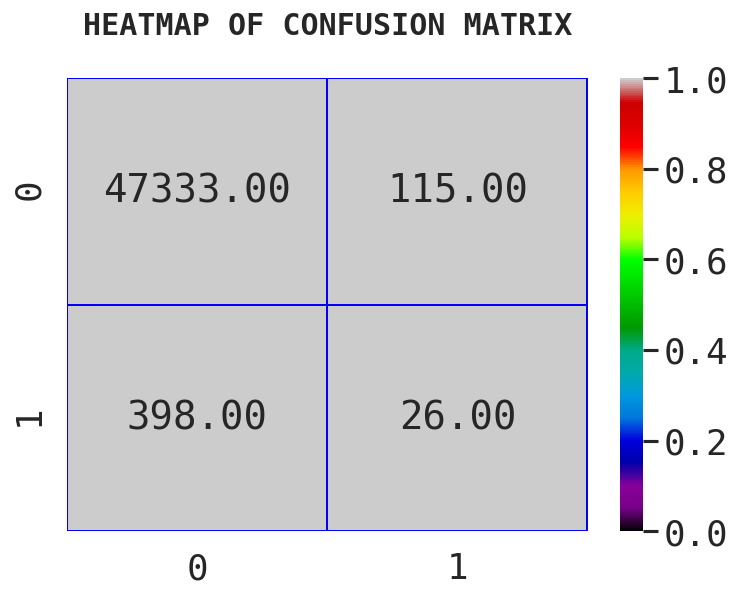



Processing normal
-------------------------------------
ACCURACY SCORE: 0.9464405080213903

F1 score: 0.9709599963756627

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.94      0.50      0.66      4844
           1       0.95      1.00      0.97     43028

    accuracy                           0.95     47872
   macro avg       0.94      0.75      0.81     47872
weighted avg       0.95      0.95      0.94     47872


PRECISION:
 0.9469777306468717

RECALL:
 0.9961885284001115

MEAN SQUARED ERROR:
 0.053559491978609625

ROOT MEAN SQ. ERROR:
 0.23142923751896524

LOG_LOSS: 1.8499194040437728

AUC_ROC Score:
 0.7503651147368022

TPR: [0.        0.4954583 1.       ] 
FPR: [0.         0.99618853 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



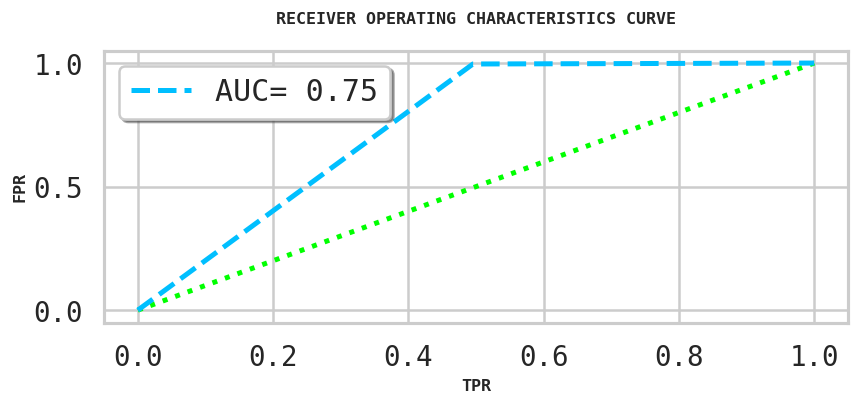





	____________________________________________CONFUSION MATRIX___________________________________________



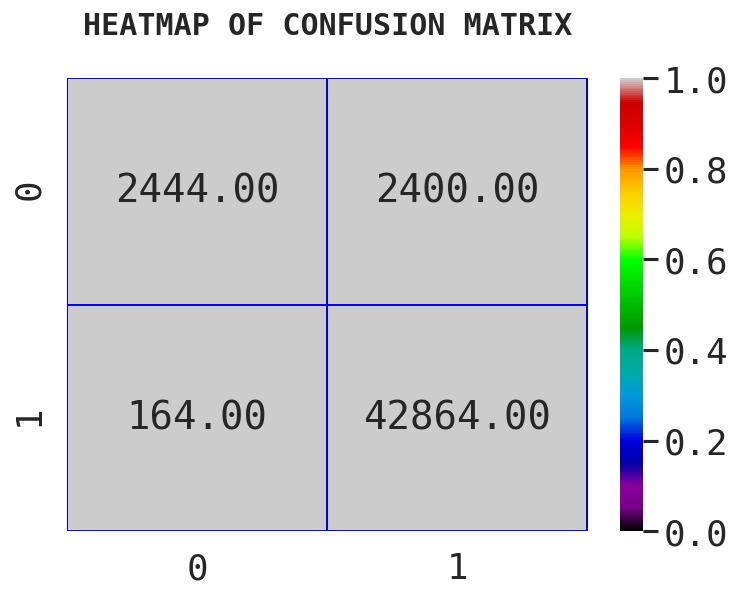

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.640663,0.947464,0.924155,0.490269,0.229207,0.052536,0.743010,1.814530
1,highly_malignant,0.237537,0.989138,0.344681,0.181208,0.104222,0.010862,0.588980,0.375173
2,rude,0.639857,0.970442,0.887712,0.500199,0.171924,0.029558,0.748347,1.020899
3,threat,0.027397,0.995551,0.035714,0.022222,0.066704,0.004449,0.510263,0.153677
4,abuse,0.542460,0.966348,0.809322,0.407945,0.183445,0.033652,0.701502,1.162311
5,loathe,0.092035,0.989284,0.184397,0.061321,0.103518,0.010716,0.529449,0.370122
6,normal,0.970960,0.946441,0.946978,0.996189,0.231429,0.053559,0.750365,1.849919


In [51]:
MNB_pipeline = Pipeline([('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    MNB_pipeline.fit(x_train, y_train[category])
    pred = MNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,5),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model

mnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
mnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### COMPLEMENT NB

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8847342914438503

F1 score: 0.5907742509641056

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     43299
           1       0.45      0.87      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.72      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.4469756480754124

RECALL:
 0.8709818499890662

MEAN SQUARED ERROR:
 0.11526570855614973

ROOT MEAN SQ. ERROR:
 0.3395080390154992

LOG_LOSS: 3.9812188453219663

AUC_ROC Score:
 0.8785842989754565

TPR: [0.         0.11381325 1.        ] 
FPR: [0.         0.87098185 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



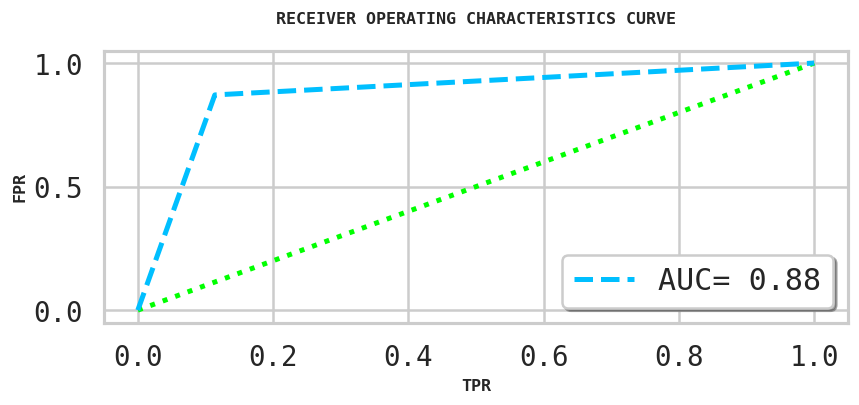





	____________________________________________CONFUSION MATRIX___________________________________________



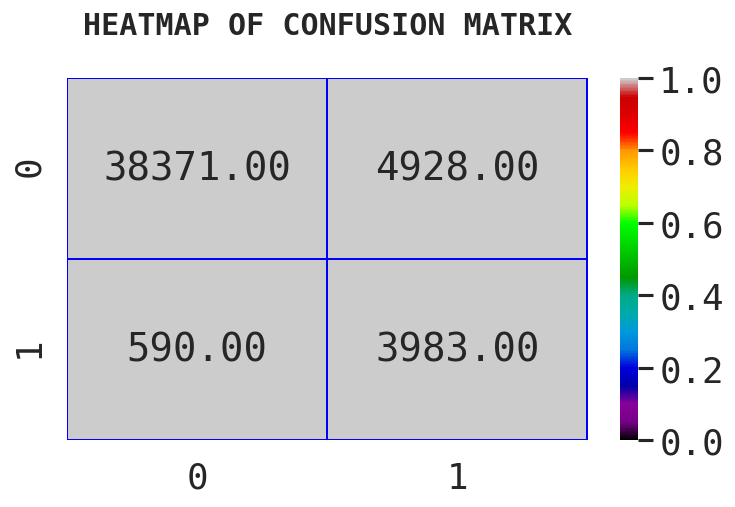



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9373119986631016

F1 score: 0.2041898700609918

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.12      0.86      0.20       447

    accuracy                           0.94     47872
   macro avg       0.56      0.90      0.59     47872
weighted avg       0.99      0.94      0.96     47872


PRECISION:
 0.11582430806257521

RECALL:
 0.8612975391498882

MEAN SQUARED ERROR:
 0.06268800133689839

ROOT MEAN SQ. ERROR:
 0.25037572034224564

LOG_LOSS: 2.165215950408889

AUC_ROC Score:
 0.899663002574417

TPR: [0.         0.06197153 1.        ] 
FPR: [0.         0.86129754 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



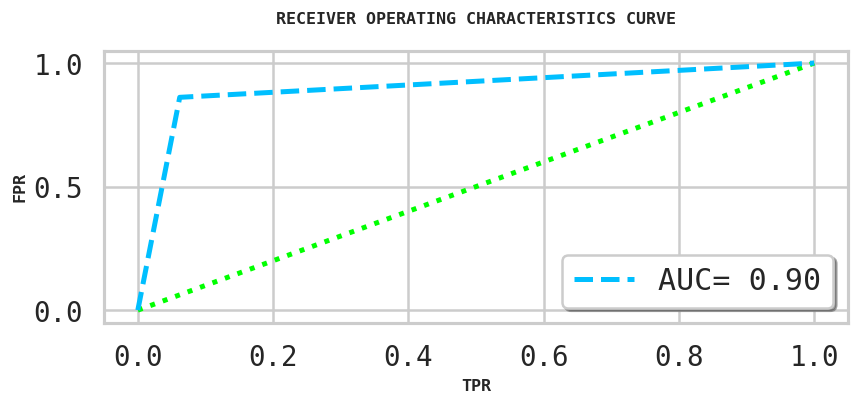





	____________________________________________CONFUSION MATRIX___________________________________________



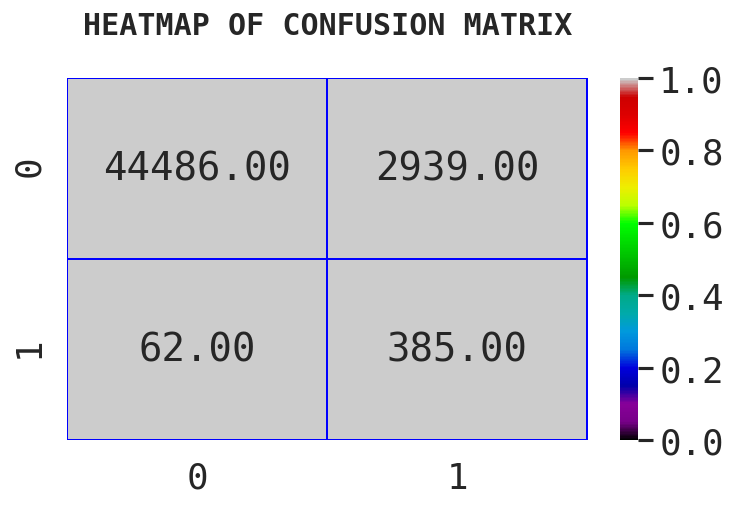



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9062708890374331

F1 score: 0.4949915588069781

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45359
           1       0.35      0.88      0.49      2513

    accuracy                           0.91     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.91      0.92     47872


PRECISION:
 0.3451035781544256

RECALL:
 0.875049741345006

MEAN SQUARED ERROR:
 0.09372911096256685

ROOT MEAN SQ. ERROR:
 0.30615210429224043

LOG_LOSS: 3.2373585061004446

AUC_ROC Score:
 0.8915251793212827

TPR: [0.         0.09199938 1.        ] 
FPR: [0.         0.87504974 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



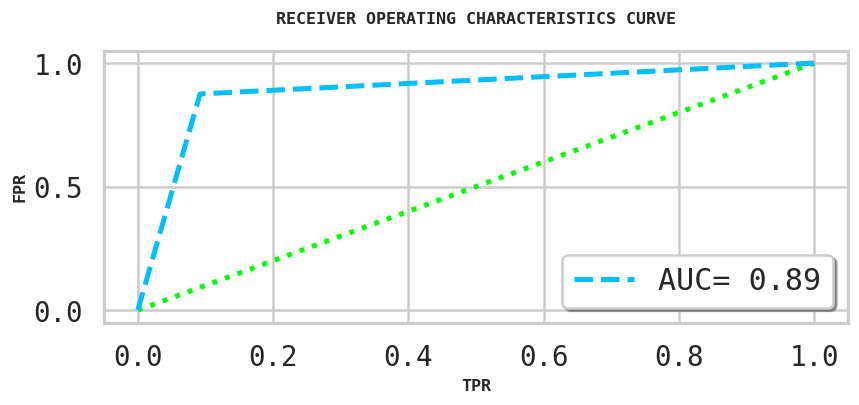





	____________________________________________CONFUSION MATRIX___________________________________________



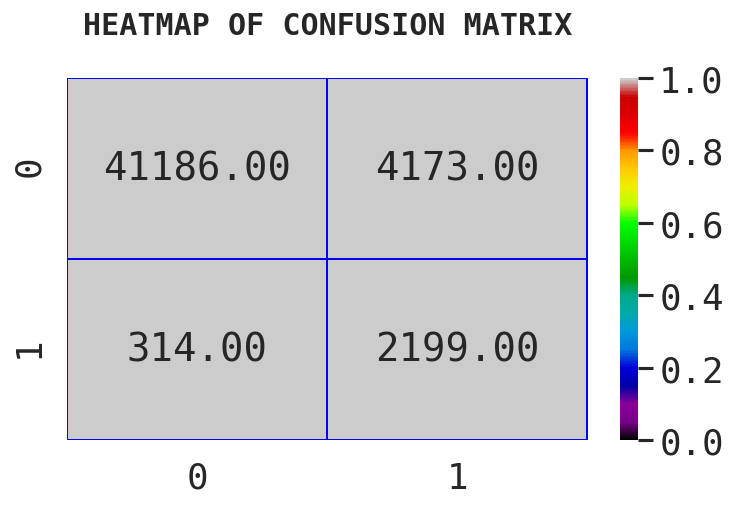



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9490725267379679

F1 score: 0.061585835257890686

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47737
           1       0.03      0.59      0.06       135

    accuracy                           0.95     47872
   macro avg       0.52      0.77      0.52     47872
weighted avg       1.00      0.95      0.97     47872


PRECISION:
 0.032480714575720666

RECALL:
 0.5925925925925926

MEAN SQUARED ERROR:
 0.050927473262032084

ROOT MEAN SQ. ERROR:
 0.22567116178641897

LOG_LOSS: 1.7590124141767305

AUC_ROC Score:
 0.7713366214109872

TPR: [0.         0.04991935 1.        ] 
FPR: [0.         0.59259259 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



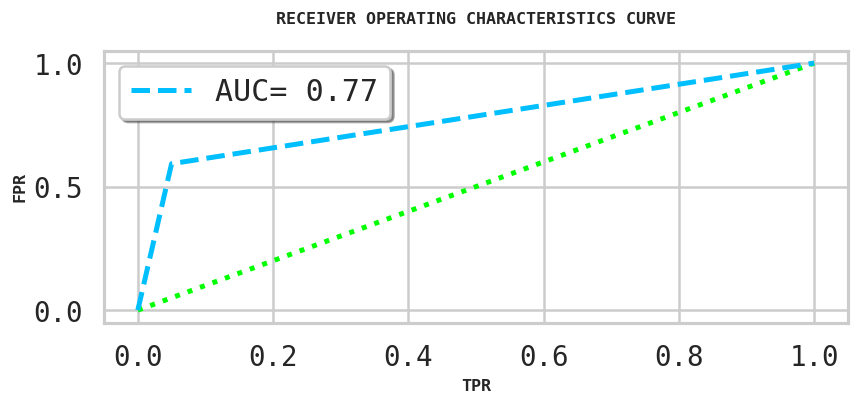





	____________________________________________CONFUSION MATRIX___________________________________________



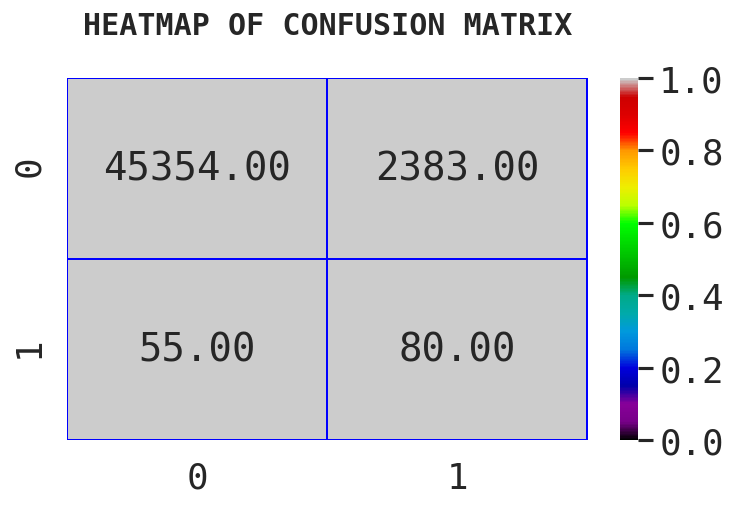



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9048922125668449

F1 score: 0.47394569612940496

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45531
           1       0.32      0.88      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.32483370288248337

RECALL:
 0.8761213156770611

MEAN SQUARED ERROR:
 0.09510778743315508

ROOT MEAN SQ. ERROR:
 0.3083955048848071

LOG_LOSS: 3.2849778076928753

AUC_ROC Score:
 0.8912463994211886

TPR: [0.         0.09362852 1.        ] 
FPR: [0.         0.87612132 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



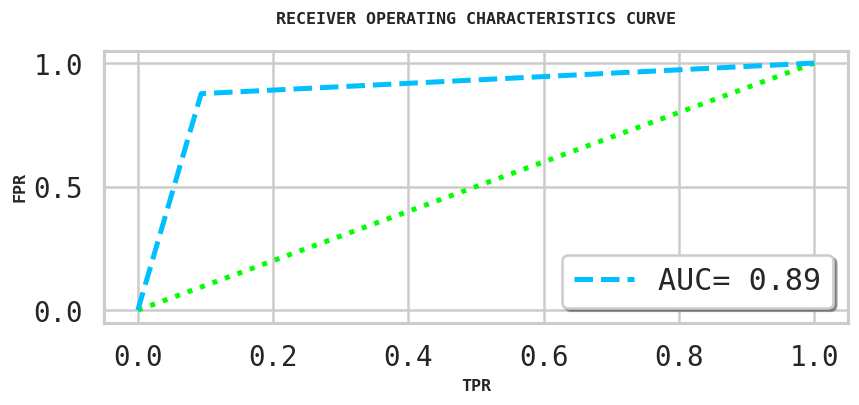





	____________________________________________CONFUSION MATRIX___________________________________________



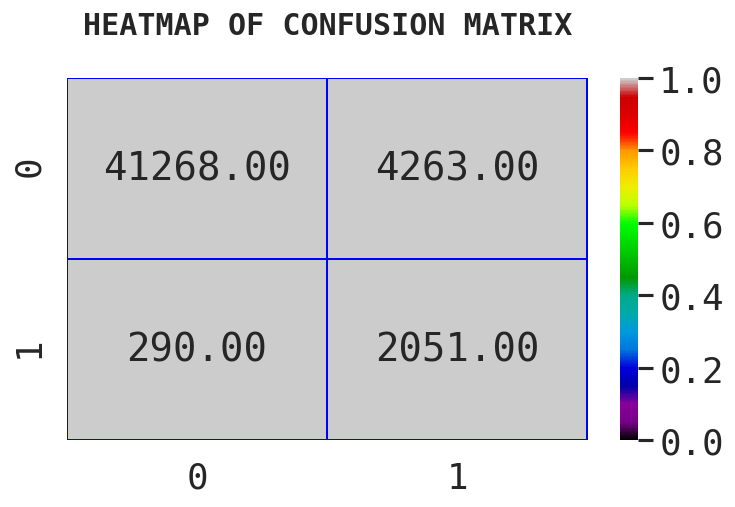



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9291026069518716

F1 score: 0.16031667491340917

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     47448
           1       0.09      0.76      0.16       424

    accuracy                           0.93     47872
   macro avg       0.54      0.85      0.56     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.08955223880597014

RECALL:
 0.7641509433962265

MEAN SQUARED ERROR:
 0.07089739304812834

ROOT MEAN SQ. ERROR:
 0.2662656437622555

LOG_LOSS: 2.4487642245626247

AUC_ROC Score:
 0.8473637873278552

TPR: [0.         0.06942337 1.        ] 
FPR: [0.         0.76415094 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



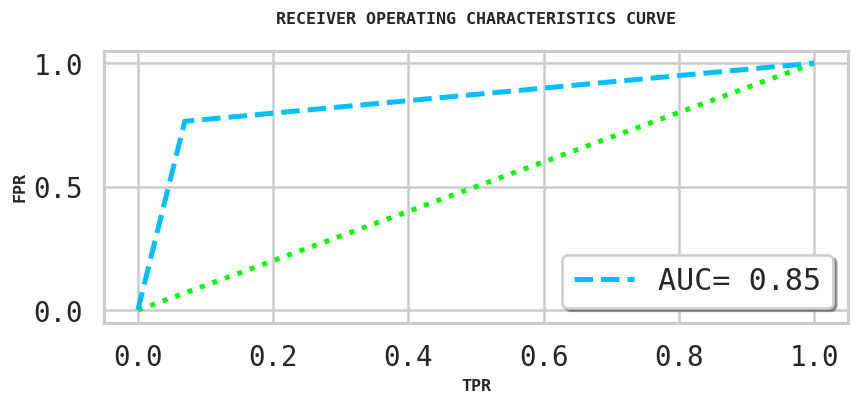





	____________________________________________CONFUSION MATRIX___________________________________________



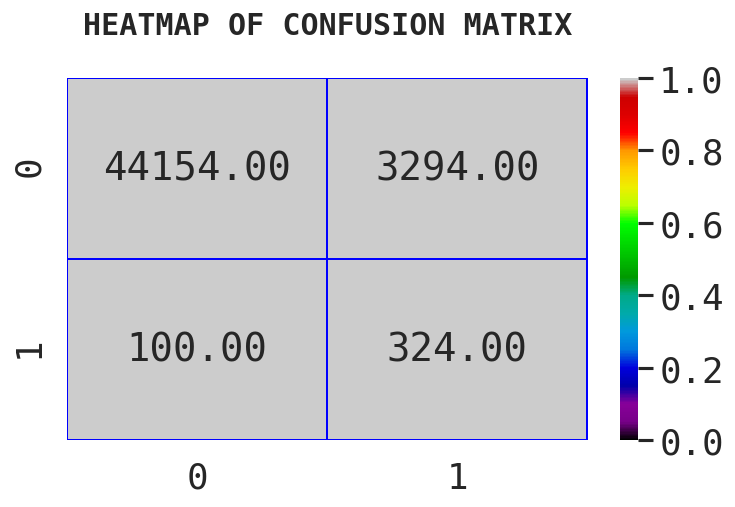



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8727230949197861

F1 score: 0.9248621918585294

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.44      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9851824606573313

RECALL:
 0.8715022775866877

MEAN SQUARED ERROR:
 0.12727690508021391

ROOT MEAN SQ. ERROR:
 0.3567588892798803

LOG_LOSS: 4.395997985192627

AUC_ROC Score:
 0.8775347886694794

TPR: [0.        0.1164327 1.       ] 
FPR: [0.         0.87150228 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



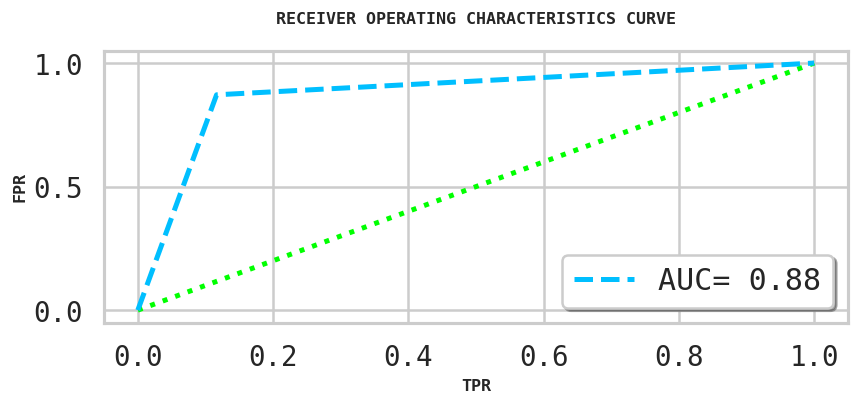





	____________________________________________CONFUSION MATRIX___________________________________________



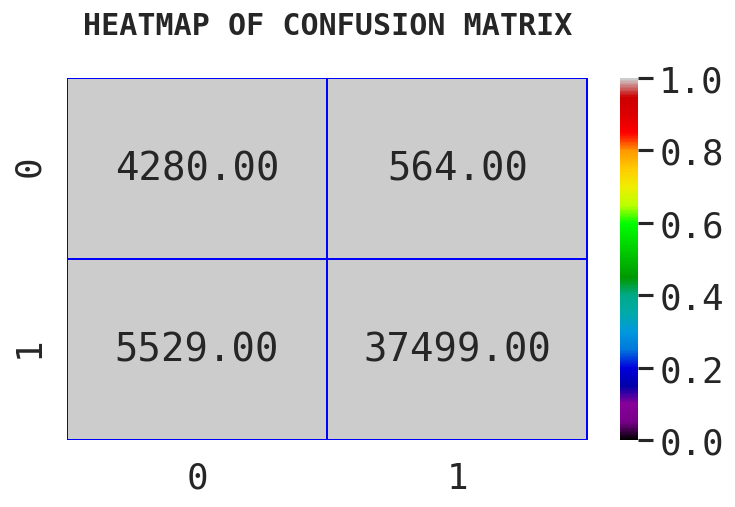

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590774,0.884734,0.446976,0.870982,0.339508,0.115266,0.878584,3.981219
1,highly_malignant,0.204190,0.937312,0.115824,0.861298,0.250376,0.062688,0.899663,2.165216
2,rude,0.494992,0.906271,0.345104,0.875050,0.306152,0.093729,0.891525,3.237359
3,threat,0.061586,0.949073,0.032481,0.592593,0.225671,0.050927,0.771337,1.759012
4,abuse,0.473946,0.904892,0.324834,0.876121,0.308396,0.095108,0.891246,3.284978
5,loathe,0.160317,0.929103,0.089552,0.764151,0.266266,0.070897,0.847364,2.448764
6,normal,0.924862,0.872723,0.985182,0.871502,0.356759,0.127277,0.877535,4.395998


In [52]:
CNB_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    CNB_pipeline.fit(x_train, y_train[category])
    pred = CNB_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
cnb_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
cnb_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

### LINEAR SVC

Processing malignant
-------------------------------------
ACCURACY SCORE: 0.8847342914438503

F1 score: 0.5907742509641056

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93     43299
           1       0.45      0.87      0.59      4573

    accuracy                           0.88     47872
   macro avg       0.72      0.88      0.76     47872
weighted avg       0.93      0.88      0.90     47872


PRECISION:
 0.4469756480754124

RECALL:
 0.8709818499890662

MEAN SQUARED ERROR:
 0.11526570855614973

ROOT MEAN SQ. ERROR:
 0.3395080390154992

LOG_LOSS: 3.9812188453219663

AUC_ROC Score:
 0.8785842989754565

TPR: [0.         0.11381325 1.        ] 
FPR: [0.         0.87098185 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



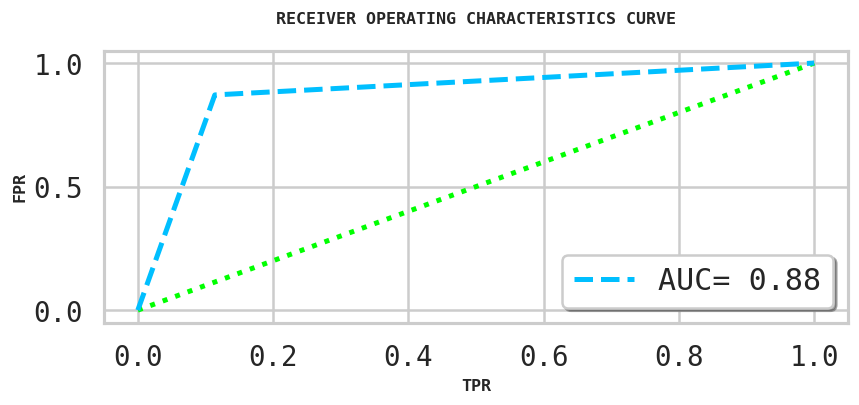





	____________________________________________CONFUSION MATRIX___________________________________________



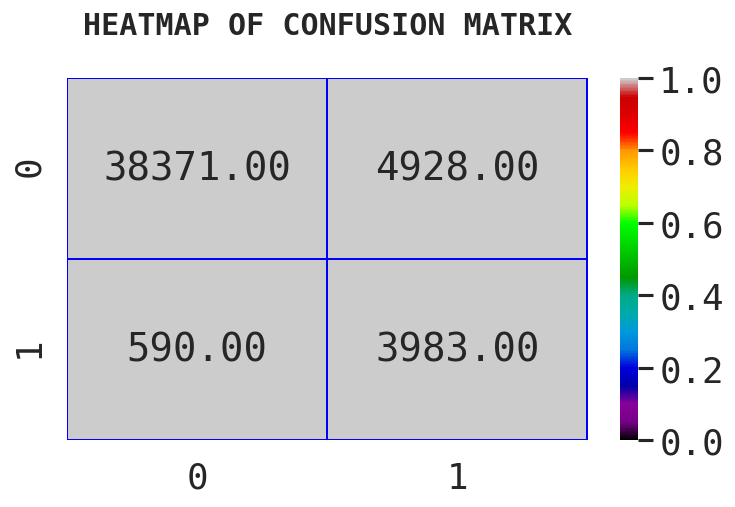



Processing highly_malignant
-------------------------------------
ACCURACY SCORE: 0.9373119986631016

F1 score: 0.2041898700609918

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     47425
           1       0.12      0.86      0.20       447

    accuracy                           0.94     47872
   macro avg       0.56      0.90      0.59     47872
weighted avg       0.99      0.94      0.96     47872


PRECISION:
 0.11582430806257521

RECALL:
 0.8612975391498882

MEAN SQUARED ERROR:
 0.06268800133689839

ROOT MEAN SQ. ERROR:
 0.25037572034224564

LOG_LOSS: 2.165215950408889

AUC_ROC Score:
 0.899663002574417

TPR: [0.         0.06197153 1.        ] 
FPR: [0.         0.86129754 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



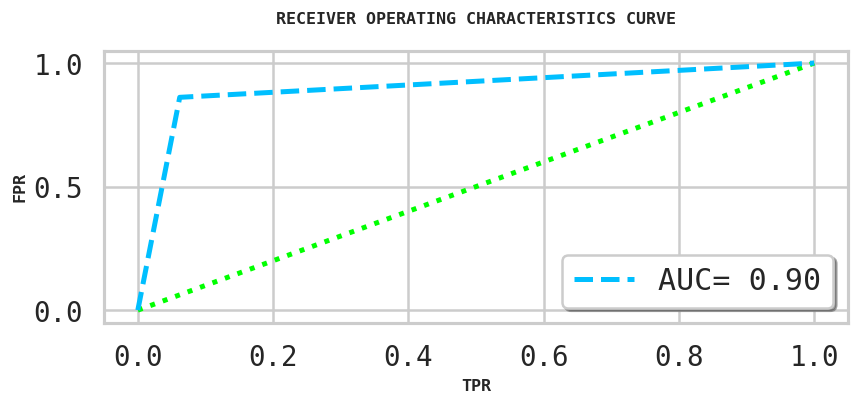





	____________________________________________CONFUSION MATRIX___________________________________________



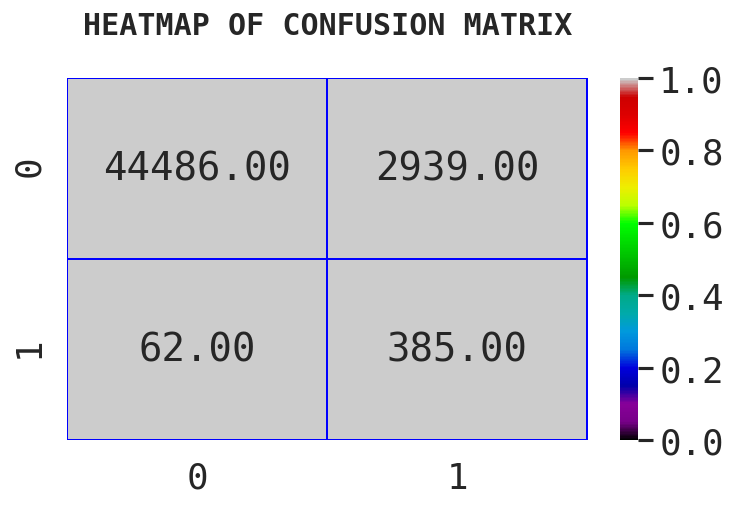



Processing rude
-------------------------------------
ACCURACY SCORE: 0.9062708890374331

F1 score: 0.4949915588069781

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45359
           1       0.35      0.88      0.49      2513

    accuracy                           0.91     47872
   macro avg       0.67      0.89      0.72     47872
weighted avg       0.96      0.91      0.92     47872


PRECISION:
 0.3451035781544256

RECALL:
 0.875049741345006

MEAN SQUARED ERROR:
 0.09372911096256685

ROOT MEAN SQ. ERROR:
 0.30615210429224043

LOG_LOSS: 3.2373585061004446

AUC_ROC Score:
 0.8915251793212827

TPR: [0.         0.09199938 1.        ] 
FPR: [0.         0.87504974 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



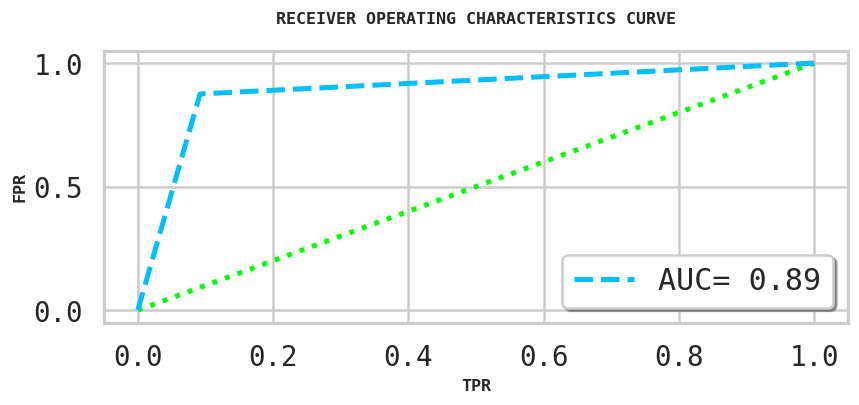





	____________________________________________CONFUSION MATRIX___________________________________________



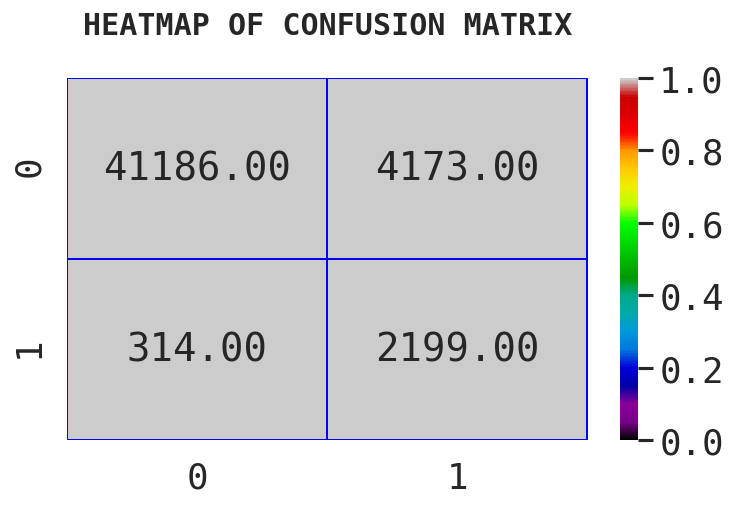



Processing threat
-------------------------------------
ACCURACY SCORE: 0.9490725267379679

F1 score: 0.061585835257890686

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     47737
           1       0.03      0.59      0.06       135

    accuracy                           0.95     47872
   macro avg       0.52      0.77      0.52     47872
weighted avg       1.00      0.95      0.97     47872


PRECISION:
 0.032480714575720666

RECALL:
 0.5925925925925926

MEAN SQUARED ERROR:
 0.050927473262032084

ROOT MEAN SQ. ERROR:
 0.22567116178641897

LOG_LOSS: 1.7590124141767305

AUC_ROC Score:
 0.7713366214109872

TPR: [0.         0.04991935 1.        ] 
FPR: [0.         0.59259259 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



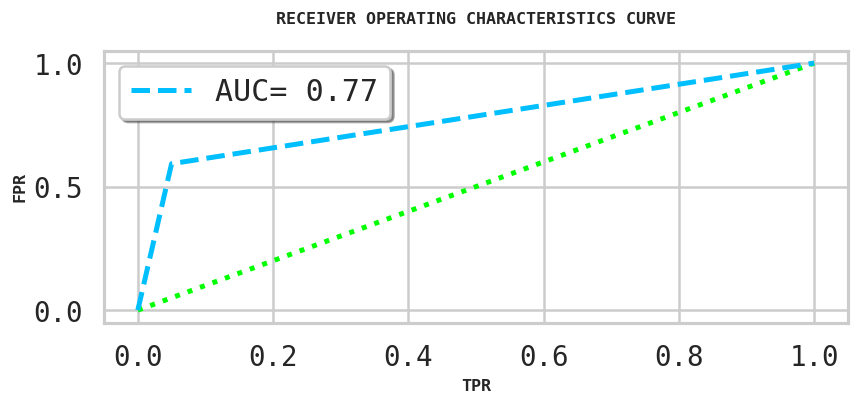





	____________________________________________CONFUSION MATRIX___________________________________________



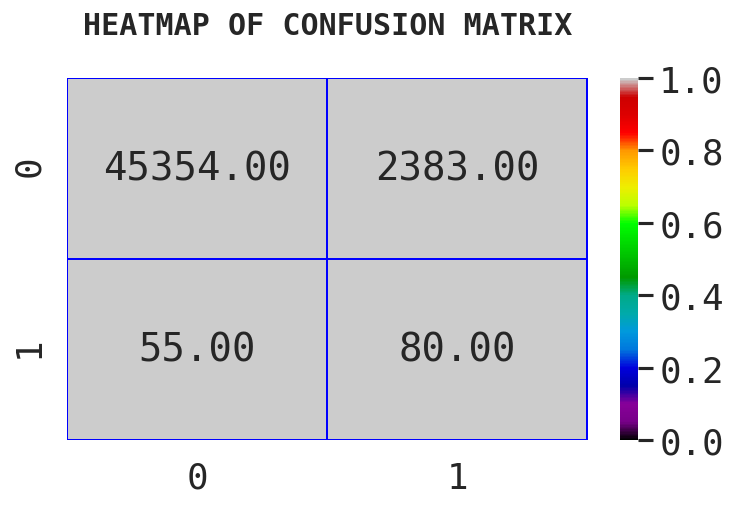



Processing abuse
-------------------------------------
ACCURACY SCORE: 0.9048922125668449

F1 score: 0.47394569612940496

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     45531
           1       0.32      0.88      0.47      2341

    accuracy                           0.90     47872
   macro avg       0.66      0.89      0.71     47872
weighted avg       0.96      0.90      0.92     47872


PRECISION:
 0.32483370288248337

RECALL:
 0.8761213156770611

MEAN SQUARED ERROR:
 0.09510778743315508

ROOT MEAN SQ. ERROR:
 0.3083955048848071

LOG_LOSS: 3.2849778076928753

AUC_ROC Score:
 0.8912463994211886

TPR: [0.         0.09362852 1.        ] 
FPR: [0.         0.87612132 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



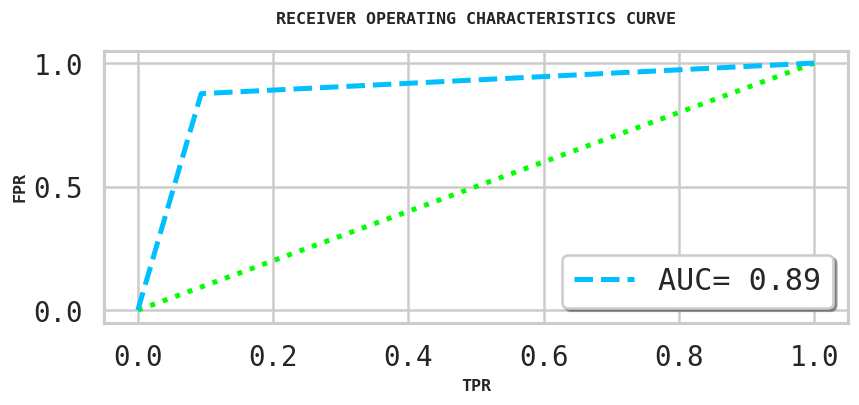





	____________________________________________CONFUSION MATRIX___________________________________________



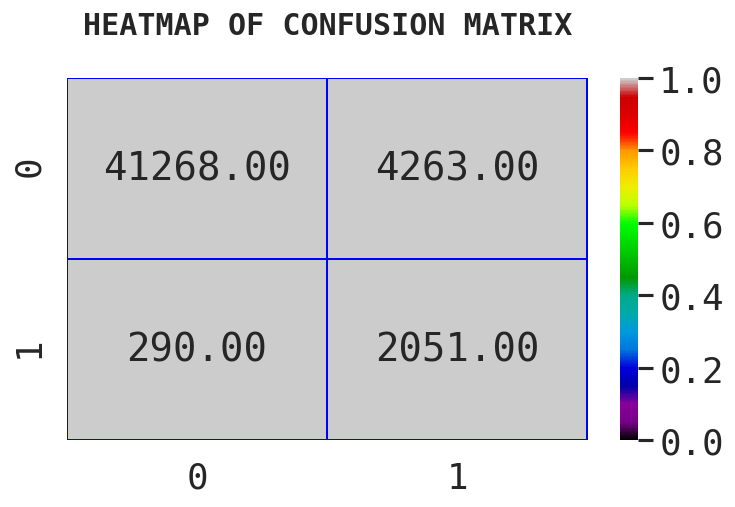



Processing loathe
-------------------------------------
ACCURACY SCORE: 0.9291026069518716

F1 score: 0.16031667491340917

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     47448
           1       0.09      0.76      0.16       424

    accuracy                           0.93     47872
   macro avg       0.54      0.85      0.56     47872
weighted avg       0.99      0.93      0.96     47872


PRECISION:
 0.08955223880597014

RECALL:
 0.7641509433962265

MEAN SQUARED ERROR:
 0.07089739304812834

ROOT MEAN SQ. ERROR:
 0.2662656437622555

LOG_LOSS: 2.4487642245626247

AUC_ROC Score:
 0.8473637873278552

TPR: [0.         0.06942337 1.        ] 
FPR: [0.         0.76415094 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



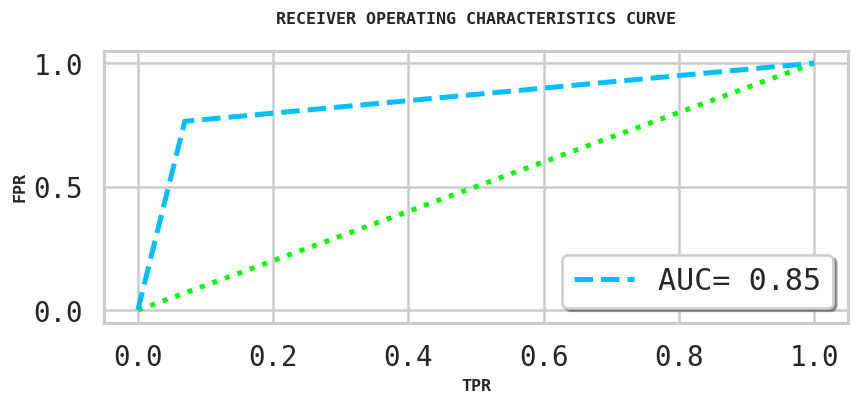





	____________________________________________CONFUSION MATRIX___________________________________________



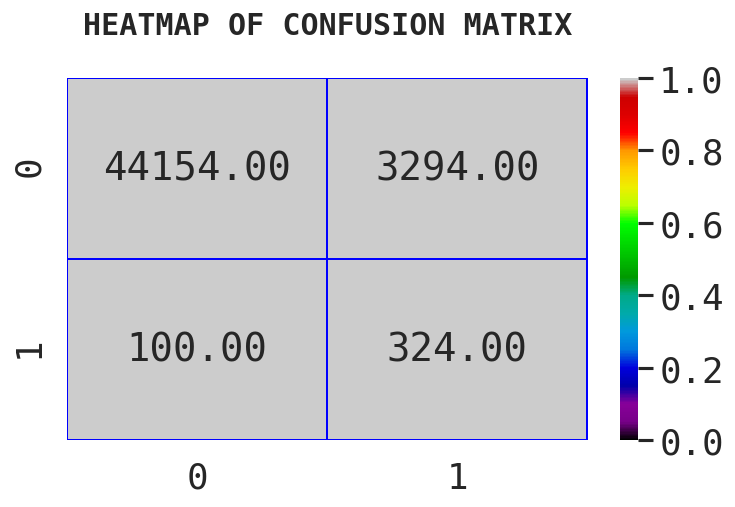



Processing normal
-------------------------------------
ACCURACY SCORE: 0.8727230949197861

F1 score: 0.9248621918585294

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.44      0.88      0.58      4844
           1       0.99      0.87      0.92     43028

    accuracy                           0.87     47872
   macro avg       0.71      0.88      0.75     47872
weighted avg       0.93      0.87      0.89     47872


PRECISION:
 0.9851824606573313

RECALL:
 0.8715022775866877

MEAN SQUARED ERROR:
 0.12727690508021391

ROOT MEAN SQ. ERROR:
 0.3567588892798803

LOG_LOSS: 4.395997985192627

AUC_ROC Score:
 0.8775347886694794

TPR: [0.        0.1164327 1.       ] 
FPR: [0.         0.87150228 1.        ]




	____________________________________________ROC_AUC CURVE_______________________________________________



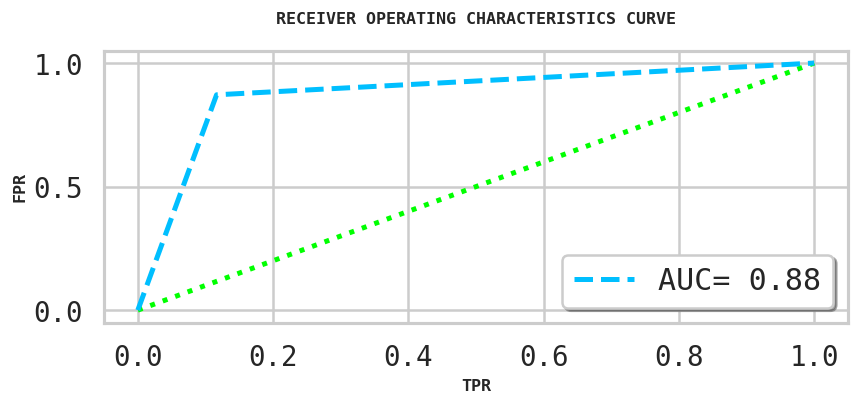





	____________________________________________CONFUSION MATRIX___________________________________________



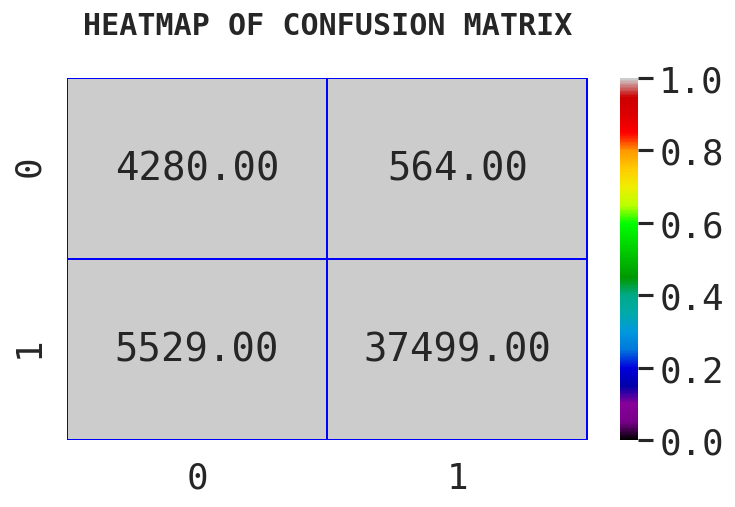

,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590774,0.884734,0.446976,0.870982,0.339508,0.115266,0.878584,3.981219
1,highly_malignant,0.204190,0.937312,0.115824,0.861298,0.250376,0.062688,0.899663,2.165216
2,rude,0.494992,0.906271,0.345104,0.875050,0.306152,0.093729,0.891525,3.237359
3,threat,0.061586,0.949073,0.032481,0.592593,0.225671,0.050927,0.771337,1.759012
4,abuse,0.473946,0.904892,0.324834,0.876121,0.308396,0.095108,0.891246,3.284978
5,loathe,0.160317,0.929103,0.089552,0.764151,0.266266,0.070897,0.847364,2.448764
6,normal,0.924862,0.872723,0.985182,0.871502,0.356759,0.127277,0.877535,4.395998


In [53]:
svc_pipeline = Pipeline([('clf', OneVsRestClassifier(ComplementNB(fit_prior=True, class_prior=None), n_jobs=-1))])
F1=[]
ACCURACY = []
PRECESION = []
RECALL = []
RMSE = []
MSE = []
AUC=[]
TPR=[]
FPR=[]
CV_ACC=[]
LOG_LOSS=[]
for category in labels:
    print('Processing {}'.format(category))
    print('-------------------------------------')
    svc_pipeline.fit(x_train, y_train[category])
    pred = svc_pipeline.predict(x_test)
    f1=f1_score(pred,y_test[category])
    acc=accuracy_score(pred,y_test[category])
    clr=classification_report(y_test[category],pred)
    pre=precision_score(y_test[category],pred)
    rec=recall_score(y_test[category],pred)
    mse=mean_squared_error(y_test[category],pred)
    rmse=np.sqrt(mse)
    log = log_loss( y_test[category],pred)
    auc_scr=roc_auc_score(y_test[category],pred)
    tpr,fpr,threshold=roc_curve(y_test[category],pred)
    conf=confusion_matrix(y_test[category],pred)
        

    print('ACCURACY SCORE:', acc)
    print('\nF1 score:',f1)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nLOG_LOSS:',log)
    print('\nAUC_ROC Score:\n',auc_scr)
    print('\nTPR:',tpr,'\nFPR:',fpr)
    print('\n')
    #plotting the auc_roc curve
    print('\n\n\t____________________________________________ROC_AUC CURVE_______________________________________________')
    print()
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1)
    plt.figure(figsize=(8,3),dpi=120)
    plt.plot([0,1],[0,1],color='lime',linestyle=":",lw=3)
    plt.plot(tpr,fpr,label="AUC= %0.2f" % auc_scr,color='deepskyblue',lw=3,linestyle='--')
    plt.legend(fancybox=True,shadow=True, fontsize='medium')
    
    plt.xlabel("TPR",weight='bold',fontsize=10)
    plt.ylabel('FPR',weight='bold',fontsize=10)
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE\n',size=10,weight='bold',loc='center')
    plt.show()
    print('\n')
  #plotting confusion matrix
    print('\n\n\t____________________________________________CONFUSION MATRIX___________________________________________\n')
    sns.set(context='talk',style='whitegrid',palette='dark',font='monospace',font_scale=1.3)
    plt.figure(figsize=(7,4),dpi=120)
    sns.heatmap(conf,annot=True,fmt='.2f',vmax=1,vmin=0,cmap='nipy_spectral',linewidths=0.8, linecolor='blue')
    plt.title('HEATMAP OF CONFUSION MATRIX\n',size=18,weight='bold',loc='center')
    plt.show()
    print('\n')
    ACCURACY.append(acc)
    F1.append(f1)
    PRECESION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    AUC.append(auc_scr)
    TPR.append(tpr)
    FPR.append(fpr)
    LOG_LOSS.append(log)
    
#creating a dataframe to show the performance of the model
lsvc_results = pd.DataFrame({"LABELS":labels,"F1":F1,'Acuracy':ACCURACY,'Precision': PRECESION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,'AUC':AUC,'LOG_LOSS':LOG_LOSS})
                               
lsvc_results.style.set_properties(**{'background-color':'black','color': 'lime','border-color': 'darkorange'})                                

In [54]:
#printing all the dataframe at one place

print('\nRESULTS OBTAINED FROM LOGISTIC REGRESSION\n')
display(logi_results)
print('\nRESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER\n')
display(pac_results)
print('\nRESULTS OBTAINED FROM MULTINOMIAL NB\n')
display(mnb_results)
print('\nRESULTS OBTAINED FROM COMPLEMENT NB\n')
display(cnb_results)
print('\nRESULTS OBTAINED FROM LINER SVC\n')
display(lsvc_results)


RESULTS OBTAINED FROM LOGISTIC REGRESSION



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.723907,0.956070,0.905716,0.602887,0.209594,0.043930,0.798129,1.517281
1,highly_malignant,0.266667,0.990349,0.459016,0.187919,0.098238,0.009651,0.592916,0.333326
2,rude,0.746009,0.977398,0.909559,0.632312,0.150339,0.022602,0.814414,0.780646
3,threat,0.120000,0.997243,0.600000,0.066667,0.052511,0.002757,0.533270,0.095236
4,abuse,0.622691,0.970129,0.814355,0.504058,0.172833,0.029871,0.749075,1.031723
5,loathe,0.265655,0.991916,0.679612,0.165094,0.089911,0.008084,0.582199,0.279214
6,normal,0.975653,0.955423,0.958227,0.993725,0.211133,0.044577,0.804460,1.539673



RESULTS OBTAINED FROM PASSIVE AGGRESSIVE CLASSIFIER



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.718617,0.946294,0.719325,0.717909,0.231745,0.053706,0.844162,1.854951
1,highly_malignant,0.303371,0.989639,0.407547,0.241611,0.101789,0.010361,0.619150,0.357858
2,rude,0.745846,0.976354,0.855744,0.660963,0.153774,0.023646,0.827395,0.816722
3,threat,0.193939,0.997222,0.533333,0.118519,0.052709,0.002778,0.559113,0.095957
4,abuse,0.626212,0.968604,0.749405,0.537804,0.177190,0.031396,0.764279,1.084394
5,loathe,0.353896,0.991686,0.567708,0.257075,0.091180,0.008314,0.627663,0.287151
6,normal,0.971356,0.948362,0.968617,0.974110,0.227239,0.051638,0.846882,1.783526



RESULTS OBTAINED FROM MULTINOMIAL NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.640663,0.947464,0.924155,0.490269,0.229207,0.052536,0.743010,1.814530
1,highly_malignant,0.237537,0.989138,0.344681,0.181208,0.104222,0.010862,0.588980,0.375173
2,rude,0.639857,0.970442,0.887712,0.500199,0.171924,0.029558,0.748347,1.020899
3,threat,0.027397,0.995551,0.035714,0.022222,0.066704,0.004449,0.510263,0.153677
4,abuse,0.542460,0.966348,0.809322,0.407945,0.183445,0.033652,0.701502,1.162311
5,loathe,0.092035,0.989284,0.184397,0.061321,0.103518,0.010716,0.529449,0.370122
6,normal,0.970960,0.946441,0.946978,0.996189,0.231429,0.053559,0.750365,1.849919



RESULTS OBTAINED FROM COMPLEMENT NB



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590774,0.884734,0.446976,0.870982,0.339508,0.115266,0.878584,3.981219
1,highly_malignant,0.204190,0.937312,0.115824,0.861298,0.250376,0.062688,0.899663,2.165216
2,rude,0.494992,0.906271,0.345104,0.875050,0.306152,0.093729,0.891525,3.237359
3,threat,0.061586,0.949073,0.032481,0.592593,0.225671,0.050927,0.771337,1.759012
4,abuse,0.473946,0.904892,0.324834,0.876121,0.308396,0.095108,0.891246,3.284978
5,loathe,0.160317,0.929103,0.089552,0.764151,0.266266,0.070897,0.847364,2.448764
6,normal,0.924862,0.872723,0.985182,0.871502,0.356759,0.127277,0.877535,4.395998



RESULTS OBTAINED FROM LINER SVC



,LABELS,F1,Acuracy,Precision,Recall,RMSE,MSE,AUC,LOG_LOSS
0,malignant,0.590774,0.884734,0.446976,0.870982,0.339508,0.115266,0.878584,3.981219
1,highly_malignant,0.204190,0.937312,0.115824,0.861298,0.250376,0.062688,0.899663,2.165216
2,rude,0.494992,0.906271,0.345104,0.875050,0.306152,0.093729,0.891525,3.237359
3,threat,0.061586,0.949073,0.032481,0.592593,0.225671,0.050927,0.771337,1.759012
4,abuse,0.473946,0.904892,0.324834,0.876121,0.308396,0.095108,0.891246,3.284978
5,loathe,0.160317,0.929103,0.089552,0.764151,0.266266,0.070897,0.847364,2.448764
6,normal,0.924862,0.872723,0.985182,0.871502,0.356759,0.127277,0.877535,4.395998


```basing on the above results using  LOGISTIC REGESSION   as final model```

In [55]:
LogReg_pipeline

Pipeline(steps=[('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='sag'),
                                     n_jobs=1))])

In [56]:
joblib.dump(LogReg_pipeline,'COMMENT_LOGI.pkl')

['COMMENT_LOGI.pkl']

In [57]:
#loading the model
model=joblib.load('COMMENT_LOGI.pkl')

In [58]:
test.head(7)

,comment_text,comment
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succes ever hate sad mofuckasi bitc...
1,== From RfC == \n\n The title is fine as it is...,rfc titl fine imo
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",sourc zaw ashton lapland
3,":If you have a look back at the source, the in...",look sourc inform updat correct form guess sou...
4,I don't anonymously edit articles at all.,anonym edit articl
5,Thank you for understanding. I think very high...,thank think highli revert discuss
6,Please do not add nonsense to Wikipedia. Such ...,pleas add nonsens wikipedia edit consid vandal...


In [61]:
X=test['comment']
X

0         bitch rule succes ever hate sad mofuckasi bitc...
1                                         rfc titl fine imo
2                                  sourc zaw ashton lapland
3         look sourc inform updat correct form guess sou...
4                                        anonym edit articl
                                ...                        
153159                    total agre stuff noth toolongcrap
153160    throw field home plate faster throw cut man di...
153161    categori chang agre correct gotten confus foun...
153162    one found nation germani law return quit simil...
153163    stop alreadi bullshit welcom fool think kind e...
Name: comment, Length: 153164, dtype: object

In [64]:
tfidf=tf(input='content', encoding='utf-8', lowercase=True,stop_words='english',max_features=10000,ngram_range=(1,3))
test_x=tfidf.fit_transform(X)

In [65]:
test_x.shape

(153164, 10000)

In [66]:
result=model.predict(test_x)

In [68]:
display(result)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)